# Statistical Methodological Comparison Notebook
The point of this notebook is to walk the user through a numpyro-based comparitive analysis of a hierarchical model and one non-hierarchical multilevel model (unpooled).

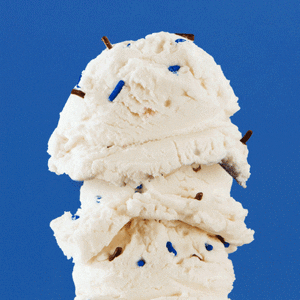

Hierarchical models are like ice cream; each layer of stack mixes with the other layers, lending them inference power. This notebook steps out to demonstrate empirically that hierarchical models are more powerful and here we carry out a careful treatment of the uncertainty quantification.

## The dataset: simple pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [2]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

from numpyro.util import enable_x64

enable_x64()

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
## plotting and analysis utilities

def display_pendulum_data(df):
    ## plot all pendulums and pendulums color-coded by planet
    color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7',
                  '#FFB7C3', '#2F2F2F', '#4A4063', '#FE5E41']
    index = 0
    for pend in np.unique(df['pendulum_id']):
        subset = df[df['pendulum_id']==pend]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = pend)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.show()

    index = 0
    for planet in np.unique(df['planet_id']):
        subset = df[df['planet_id']==planet]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = planet)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if planet > 3:
            break
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.title('pendulums color-coded by planet')
    plt.show()
    
def plot_prior_predictive(prior_pred, variable_model, variable_df, n_steps=10, title = None):
    ## plot the prior predictive histograms for parameters in the model
    label = "prior samples"
    plt.hist(
        prior_pred[variable_model].flatten(),
        n_steps,
        #range=(0.2, 3.0),
        #histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
        density=True
    )
    plt.hist(df[variable_df], n_steps, histtype="step", color="black", label="data", density=True)
    plt.legend()
    plt.xlabel(variable_model)
    plt.ylabel("density")
    plt.title(title)
    plt.show()

def pos_calculator(L, theta, a_g, sigma, time):
    ## because the sampler chain doesn't save the position at each point in time,
    ## i have created a thing that samples position for us
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma * np.random.randn(len(time))
    return pos

def how_did_we_do_on_individual_pendulums(df, posterior, n_pendulums, chain_length, pooled = False):
    ## print out the mean and standard deviation on the posterior parameters for
    ## each individual pendulum and make multiple draws from the posterior distribution
    ## to plot "theoretical" pendulum trajectories
    for number in range(n_pendulums):
        sub_df = df[df['pend_code'] == number]
        print(f"Pendulum number {number}")
        print(f"true L = {np.mean(sub_df['length'].values)}")
        print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
        print(f"true theta = {np.mean(sub_df['theta'].values)}")
        print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
        print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
        if pooled:
            print(f"posterior a_g = {round(np.median(posterior['a_g'][:]),2)} +/- {round(np.std(posterior['a_g'][:]),2)}")
        else:
            print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
        # let's actually draw from this posterior:
        plt.clf()

        
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            if pooled:
                a_g = posterior['a_g'][j]
            else:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            sigma = posterior['σ'][j]
            plt.plot(times, pos_calculator(L,theta,a_g,sigma,times), color = 'grey')
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = 'orange')
        plt.show()

def how_did_we_do_on_all_pendulums(df, posterior, n_pendulums, chain_length):
    ## plot the 3 sigma position intervals from these posteriors for all pendulums at once
    ## (should probably redo this to more cleanly see each pendulum individually)
    n_pendulums = 8
    chain_length = 2000
    # first do the first four pendulums
    # hot colors
    colors = ['#F26419', '#F6AE2D', '#820263', '#D90368']
    plt.clf()

    offset = 0
    counter_neg = 0
    for number in range(4):
        sub_df = df[df['pend_code'] == number]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            try:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            except IndexError: # for the unpooled case
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            if L < 0 or a_g < 0:
                counter_neg += 1
            y_model[j,:] = pos_calculator(abs(L),theta,abs(a_g),sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average + offset - 3 * y_std, y_average + offset + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        #plt.plot(times, y_average + offset, color = colors[number])
        #plt.scatter(sub_df['time'].values, sub_df['pos'].values + offset, zorder=100, color = colors[number])
        plt.axhline(y = offset, color = 'black')
        offset += 1 #* (number + 1)
        
    print('NUMER OF NEGATIVE PARAMS', counter_neg)
    plt.title('Pendulums on planet 1')
    plt.ylabel('each subsequent pendulum is offset by +15')
    plt.show()
    

    # second four pendulums (from planet 2) are cool colors
    colors = ['#33658A', '#86BBD8', '#2F4858', '#6CC551']
    plt.clf()
    offset = 0
    for number in range(4):
        number_2 = number + 3
        sub_df = df[df['pend_code'] == number_2]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number_2]
            theta = posterior['theta'][j,number_2]
            try:
                a_g = posterior['a_g'][j,number_2]#
            except IndexError:
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(abs(L),theta,abs(a_g),sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average + offset - 3 * y_std, y_average + offset + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average + offset, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values + offset, zorder=100, color = colors[number])
        plt.axhline(y = offset, color = 'black')
        offset += 1
    plt.title('Pendulums on planet 2')
    plt.ylabel('each subsequent pendulum is offset by +15')
    plt.show()

def make_corner_plots(posterior, data_params, pooled = False):
    data = az.from_dict(
        posterior={"L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
                   "L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                   "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                   "L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                   },
   #     sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, divergences=True, truths = data_params['length'], truth_color = '#D84797')#,
                           #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])
    plt.show()

    data = az.from_dict(
        posterior={"theta0": posterior["theta"][:,0], "theta1": posterior["theta"][:,1],
                   "theta2": posterior["theta"][:,2], "theta3": posterior["theta"][:,3],
                   "theta4": posterior["theta"][:,4], "theta5": posterior["theta"][:,5],
                   "theta6": posterior["theta"][:,6], "theta7": posterior["theta"][:,7],
                   },
        #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, truths = data_params['theta'], truth_color = '#D84797')
    plt.show()

    if pooled:
        plt.clf()
        plt.hist(posterior["a_g"], bins = 100)
        plt.axvline(x = data_params['a_g'][0])
        plt.axvline(x = data_params['a_g'][4])
        plt.show()
    else:
        data = az.from_dict(
            posterior={"ag0": posterior["a_g"][:,0], "ag1": posterior["a_g"][:,1],
                       #"L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                       #"L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                       #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                       },
            #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
        )
        print(data_params['a_g'])
        plt.clf()
        figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][4]], truth_color = '#D84797')
        plt.show()
    data = az.from_dict(
        posterior={"ag0": posterior["a_g"][:,0], "ag1": posterior["a_g"][:,1],
                   "L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
                   "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                   #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                   },
        #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][4],
                                           data_params['length'][0], data_params['length'][1],
                                           data_params['length'][4], data_params['length'][5]], truth_color = '#D84797')
    plt.show()
    
def plot_posterior_predictive_samples(df, model, posterior, rng_key, time_values, mcmc_run,
                                      pooled,
                                      title,
                                      kind = 'kde'):
    
    planet_encoder = LabelEncoder()

    planets = planet_encoder.fit_transform(df["planet_code"])
    planets = jnp.array(planets)

    pendulum_encoder = LabelEncoder()

    pendulums = pendulum_encoder.fit_transform(df["pend_code"])
    pendulums = jnp.array(pendulums)

    pooled_posterior_predictive = numpyro.infer.Predictive(
        model=model, posterior_samples=posterior
    )
    '''
    prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=50)(
        random.PRNGKey(11), planet_code, pend_code, time_values
    )
    '''
    rng_key, rng_subkey = random.split(rng_key)
    if pooled:
        print('pooled')
        pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, pendulums, time_values)
    else:
        pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, planets, pendulums, time_values)
    # convert to arviz inference data object
    pooled_idata = az.from_numpyro(
        posterior=mcmc_run, posterior_predictive=pooled_posterior_predictive_samples
    )
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6))
    az.plot_ppc(
        data=pooled_idata,
        observed_rug=True,
        ax=ax,
        kind=kind,
    )
    ax.set(
        title=title,
        xlabel="observed position",
        ylabel="count",
    )
    plt.show()
    
    
    return pooled_posterior_predictive, pooled_posterior_predictive_samples, pooled_idata
    
def compare_models(pooled_idata, unpooled_idata, hierarchical_idata, kind = 'kde'):
    plt.clf()
    fig, ax = plt.subplots(
        nrows=1, ncols=3, figsize=(12, 5), sharex=True, sharey=True#, layout="constrained"
    )

    az.plot_ppc(
        data=pooled_idata,
        observed_rug=True,
        ax=ax[0],
        kind=kind,
    )
    ax[0].set(
        title="Pooled Model",
        xlabel="x pos",
        ylabel="count",
    )
    az.plot_ppc(
        data=unpooled_idata,
        observed_rug=True,
        ax=ax[1],
        kind=kind,
    )
    ax[1].set(
        title="Unpooled",
        xlabel="x pos",
        ylabel="count",
    )
    az.plot_ppc(
        data=hierarchical_idata,
        observed_rug=True,
        ax=ax[2],
        kind=kind,
    )
    ax[2].set(
        title="Hierarchical",
        xlabel="x pos",
        ylabel="count",
    )

    fig.suptitle("Posterior Predictive Checks", y=1.06, fontsize=16)
    plt.show()
    
def investigate_distribution_posteriors(posterior_samples, inf_data):
    ## investigate the distribution
    for num in range(8):
        heights, bins = np.histogram(posterior_samples['L'][:,num], bins = 100)
        height = np.max(heights)
        p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
        plt.hist(posterior_samples['L'][:,num], color = '#D84797', bins = 100)
        plt.axvline(x = az.summary(inf_data)['mean'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num], height, 'mean', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['hdi_3%'][num], color = 'black')
        plt.text(az.summary(inf_data)['hdi_3%'][num], height, 'hdi_3%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['hdi_97%'][num], color = 'black')
        plt.text(az.summary(inf_data)['hdi_97%'][num], height, 'hdi_97%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['mean'][num] - az.summary(inf_data)['sd'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num] - az.summary(inf_data)['sd'][num], height, 'standard deviation', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['mean'][num] + az.summary(inf_data)['sd'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num] + az.summary(inf_data)['sd'][num], height, 'standard deviation', color='black', ha='right', va='top', rotation=90)

        plt.axvline(x = p3, color = 'black')
        plt.text(p3, height, '3%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = p97, color = 'black')
        plt.text(p97, height, '97%', color='black', ha='right', va='top', rotation=90)
        plt.show()
        
def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):
    chain_colors = ['#B5CA8D',
                    '#8BB174',
                    '#426B69',
                    '#222E50']
    plt.clf()
    for p in range(n_pendulums-1):


        for chain in range(n_chains-1):
            plt.plot(posterior['L'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                     color = chain_colors[chain])
        plt.axhline(y = data_params['length'][p], color = 'black')
    plt.ylim([1,25])
    plt.title('Length inference')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 10))

    for p, ax in enumerate(axs.flatten()):
        ax.axvline(x = data_params['length'][p], color = 'black')

        for chain in range(n_chains-1):
            if chain == 0:
                values, bins = np.histogram(posterior['L'][:, p],
                                             bins = 20)
                #print('values', values)
                #print('bins', bins)
            ax.hist(posterior['L'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                    bins = bins,
                    color = chain_colors[chain], histtype='bar', ec='white',
                    density = True)
        #ax.set_xlim([1,25])


    plt.show()

    plt.clf()
    for p in range(n_pendulums-1):


        for chain in range(n_chains-1):
            plt.plot(posterior['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                     color = chain_colors[chain])
        plt.axhline(y = data_params['theta'][p], color = 'black')
    plt.ylim([0, np.pi/2])
    plt.title('theta inference')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 10))

    for p, ax in enumerate(axs.flatten()):
        ax.axvline(x = data_params['theta'][p], color = 'black')
        for chain in range(n_chains-1):
            if chain == 0:
                values, bins = np.histogram(posterior['theta'][:, p],
                                             bins = 20)
                #print('values', values)
                #print('bins', bins)
            ax.hist(posterior['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                    bins = bins,
                    color = chain_colors[chain], histtype='bar', ec='white',
                    density = True)
        #ax.set_xlim([1,25])


    plt.show()
        
print('compiled')

compiled


## Hierarchical model
Again, this is the full ice cream stack model. Here, there are global values (μ_a_g and σ_a_g), from which the individual a_g values are drawn for each planet. The a_g values get information from all pendulums on a given planet AND from the global values which also are informed by the pendulums on the other planet. The L and theta are sampled for each individual planet.

Note that there is an error component (sigma) so we can directly model the overall error; this could eventually become sigma on every individual parameter.

In [30]:
exponential = 100

In [193]:
def hierarchical_model(planet_code, pendulum_code, times, pos_obs=None):
    ## inputs to a numpyro model are rows from a dataframe:
    ## planet code - array of embedded numbers representing which planet {0...1}
    ## pendulum code - array of embedded numbers representing which pendulum {0...7}
    ## times - moments in time (s)
    ## pos_obs - this is optional, set to None but used to compare the model with data
    ## (when data, xpos, is defined)
    
    ## numpyro models function by drawing parameters from samples 
    ## first, we define the global parameters, mean and sigma of a normal from
    ## which the individual a_g values of each planet will be drawn
    

    #μ_a_g = numpyro.sample("μ_a_g", dist.LogUniform(5.0,15.0))
    μ_a_g = numpyro.sample("μ_a_g", dist.TruncatedNormal(12.5, 2, low = 0.01))
    # scale parameters should be log uniform so that they don't go negative 
    # and so that they're not uniform
    # 1 / x in linear space
    σ_a_g = numpyro.sample("σ_a_g", dist.TruncatedNormal(2, 0.5, low = 0.01))
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))

    ## plates are a numpyro primitive or context manager for handing conditionally independence
    ## for instance, we wish to model a_g for each planet independently
    with numpyro.plate("planet_i", n_planets):
        #a_g = σ_a_g * numpyro.sample("a_g", dist.Normal(μ_a_g, 1))#σ_a_g))
        
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(μ_a_g, σ_a_g, low = 0.01))
        # helps because a_gs are being pulled from same normal dist
        # removes dependency of a_g on sigma_a_g on a prior level
        # removing one covariance from model, model is easier
        # to sample from
    
    ## we also wish to model L and theta for each pendulum independently
    ## here we draw from an uniform distribution
    with numpyro.plate("pend_i", n_pendulums):
        L = 5#numpyro.sample("L", dist.TruncatedNormal(5, 2, low = 0.01))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100,jnp.pi/500, low = 0.00001))

    ## σ is the error on the position measurement for each moment in time
    ## we also model this
    ## eventually, we should also model the error on each parameter independently?
    ## draw from an exponential distribution parameterized by a rate parameter
    ## the mean of an exponential distribution is 1/r where r is the rate parameter
    ## exponential distributions are never negative. This is good for error.
    σ = numpyro.sample("σ", dist.Exponential(exponential))#dist.Uniform(0, 0.1))#dist.HalfNormal(2.0))
    
    ## the moments in time are not independent, so we do not place the following in a plate
    ## instead, the brackets segment the model by pendulum and by planet,
    ## telling us how to conduct the inference
    modelx = L * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L) * times))
    ## don't forget to use jnp instead of np so jax knows what to do
    ## A BIG QUESTION I STILL HAVE IS WHAT IS THE LIKELIHOOD? IS IT JUST SAMPLED FROM?
    
    ## again, for each pendulum we compare the observed to the modeled position:
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)
        
print('compiled')

compiled


## Now non-hierarchical setup
There are many types of non-hierarchical setups. Here, we'll focus on a non-hierarchical setup that is multilevel. This type of model is called a "no pooling model". In a no pooling model, the a_g value is sampled for each planet individually without any uniting global variables). The model is still multi-level because the parameters are organized according to the groupings.

The unpooled model is like a bunch of different ice cream cones:

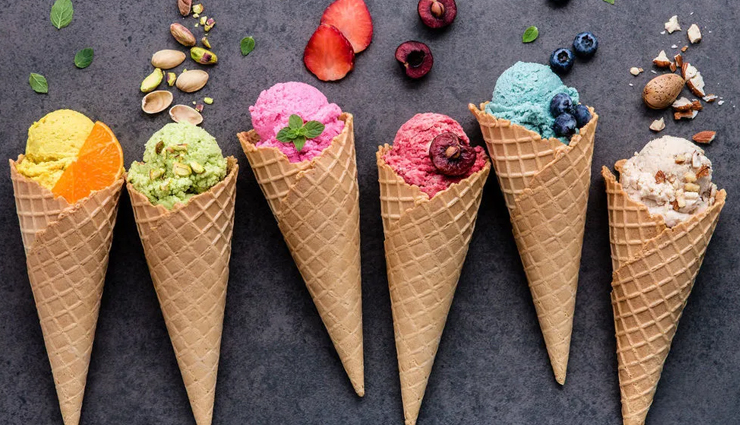

Here, the modeling is fully segmented for each planet (here, ice cream cone). This means the model has no mechanism (such as a global distribution characterized by μ_a_g and σ_a_g) to share information between groups.

In [217]:
def unpooled_model(planet_code, pendulum_code, times, pos_obs=None):
    
    n_planets = len(np.unique(planet_code))
    n_pendulums = len(np.unique(pendulum_code))
    
    with numpyro.plate("planet_i", n_planets):
        #10.0, 1.0
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(10, 5, low = 0, high = 25))#dist.Uniform(13, 16))#

    with numpyro.plate("pend_i", n_pendulums):
        L = 5#numpyro.sample("L", dist.TruncatedNormal(5, 2, low = 0.01))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100,jnp.pi/500, low = 0.00001))

    σ = numpyro.sample("σ", dist.Exponential(exponential))#dist.HalfNormal(2.0))
    modelx = L * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g[planet_code] / L) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums; four each on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [194]:
import deepbench
from deepbench.physics_object import Pendulum

# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

length_df = 100
xs = np.zeros((2*length_df, 3))
labels = np.zeros((2*length_df, 2))
error = []
y_noisy = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    length = 5#abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500))
    a_g = 10.0#abs(rs.normal(loc=10, scale=1))
    xs[r,:] = [length, theta, a_g]
    labels[r,:] = [0, r]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    # because for now there is no error
    dx_dthing = length * np.cos(theta * np.cos(np.sqrt(a_g / length) * time)) * \
              np.cos(np.sqrt(a_g / length) * time) * theta_percent_error_all * theta
    error.append(dx_dthing)
    del pendulum

# and do it again for a different planet
for r in range(length_df):
    r = r + length_df
    rs = np.random.RandomState()#2147483648)# 
    length = 5#abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500))
    a_g = 15.0#abs(rs.normal(loc=15, scale=1))
    xs[r,:] = [length, theta, a_g]
    labels[r,:] = [1, r]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    # because for now there is no error
    dx_dthing = length * np.cos(theta * np.cos(np.sqrt(a_g / length) * time)) * \
              np.cos(np.sqrt(a_g / length) * time) * theta_percent_error_all * theta
    error.append(dx_dthing)
    del pendulum

Now make this into a df with columns for planet number and pendulum number.

In [195]:
data_params = {
    'length': xs[:,0],
    'theta': xs[:,1],
    'a_g': xs[:,2],
    'planet_id': labels[:,0],
    'pendulum_id': labels[:,1],
    'pos_err': error,
    
}

## create the DataFrame
df = pd.DataFrame(data_params)
df['pos'] = y_noisy
df['time'] = np.repeat(time,2*length_df)

pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time_values = df["time"].values
pend_code = df["pend_code"].values

df = df[["length","theta","a_g","pos","pos_err","pend_code","planet_code","time"]]

df

length     theta   a_g       pos   pos_err  pend_code  planet_code  time
0       5.0  0.018761  10.0  0.057428  0.004580          0            0  0.75
1       5.0  0.030132  10.0  0.080207  0.007356          1            0  0.75
2       5.0  0.044476  10.0  0.083612  0.010856          2            0  0.75
3       5.0  0.024699  10.0  0.058729  0.006030          3            0  0.75
4       5.0  0.036184  10.0  0.086568  0.008833          4            0  0.75
..      ...       ...   ...       ...       ...        ...          ...   ...
195     5.0  0.033538  15.0  0.046253  0.004501        195            1  0.75
196     5.0  0.028266  15.0  0.041363  0.003793        196            1  0.75
197     5.0  0.039572  15.0  0.056879  0.005311        197            1  0.75
198     5.0  0.026799  15.0  0.039915  0.003597        198            1  0.75
199     5.0  0.021022  15.0  0.027689  0.002821        199            1  0.75

[200 rows x 8 columns]

Let's just visualize this a little bit.

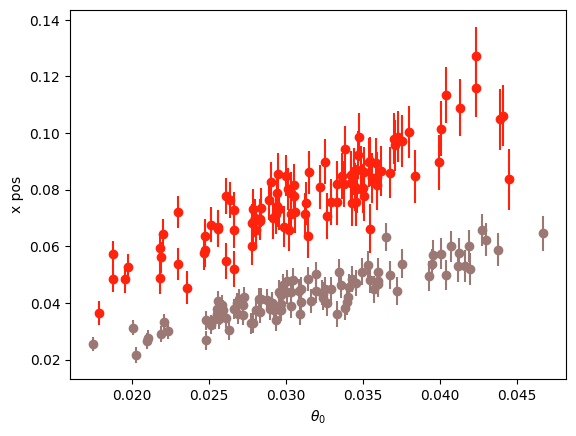

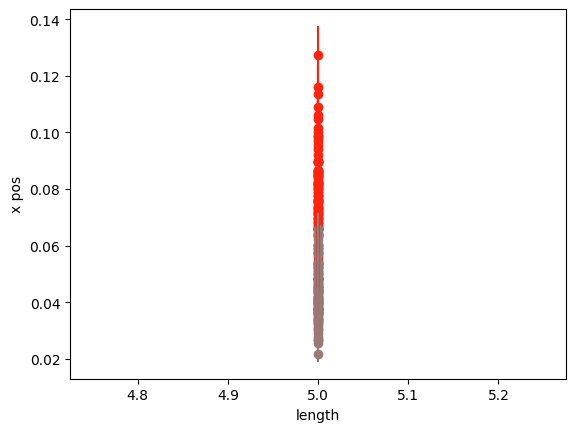

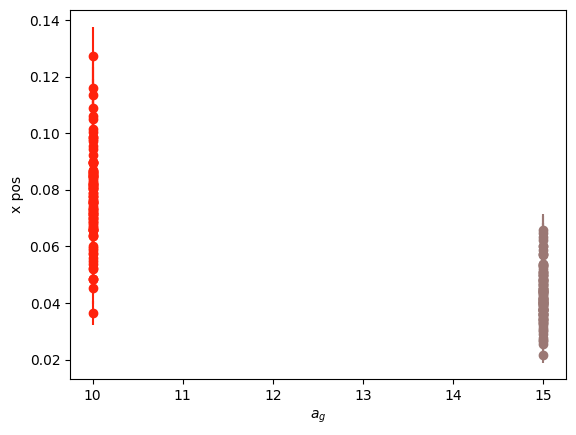

In [196]:
plt.clf()
plt.scatter(df[df['planet_code']==0]['theta'].values, df[df['planet_code']==0]['pos'].values, color = '#FF220C')
plt.errorbar(df[df['planet_code']==0]['theta'].values, df[df['planet_code']==0]['pos'].values,
             yerr = df[df['planet_code']==0]['pos_err'].values, linestyle = 'None',
             color = '#FF220C')
plt.scatter(df[df['planet_code']==1]['theta'].values, df[df['planet_code']==1]['pos'].values, color = '#9B7874')
plt.errorbar(df[df['planet_code']==1]['theta'].values, df[df['planet_code']==1]['pos'].values,
             yerr = df[df['planet_code']==1]['pos_err'].values, linestyle = 'None',
             color = '#9B7874')
plt.xlabel(r'$\theta_0$')
plt.ylabel('x pos')
plt.show()

plt.clf()
plt.scatter(df[df['planet_code']==0]['length'].values, df[df['planet_code']==0]['pos'].values, color = '#FF220C')
plt.errorbar(df[df['planet_code']==0]['length'].values, df[df['planet_code']==0]['pos'].values,
             yerr = df[df['planet_code']==0]['pos_err'].values, linestyle = 'None',
             color = '#FF220C')
plt.scatter(df[df['planet_code']==1]['length'].values, df[df['planet_code']==1]['pos'].values, color = '#9B7874')
plt.errorbar(df[df['planet_code']==1]['length'].values, df[df['planet_code']==1]['pos'].values,
             yerr = df[df['planet_code']==1]['pos_err'].values, linestyle = 'None',
             color = '#9B7874')
plt.xlabel(r'length')
plt.ylabel('x pos')
plt.show()

plt.clf()
plt.scatter(df[df['planet_code']==0]['a_g'].values, df[df['planet_code']==0]['pos'].values, color = '#FF220C')
plt.errorbar(df[df['planet_code']==0]['a_g'].values, df[df['planet_code']==0]['pos'].values,
             yerr = df[df['planet_code']==0]['pos_err'].values, linestyle = 'None',
             color = '#FF220C')
plt.scatter(df[df['planet_code']==1]['a_g'].values, df[df['planet_code']==1]['pos'].values, color = '#9B7874')
plt.errorbar(df[df['planet_code']==1]['a_g'].values, df[df['planet_code']==1]['pos'].values,
             yerr = df[df['planet_code']==1]['pos_err'].values, linestyle = 'None',
             color = '#9B7874')
plt.xlabel(r'$a_g$')
plt.ylabel('x pos')
plt.show()

## Visualize the probabilistic graph
Numpyro has some neat tools for creating DAGS - directive acyclic graphs

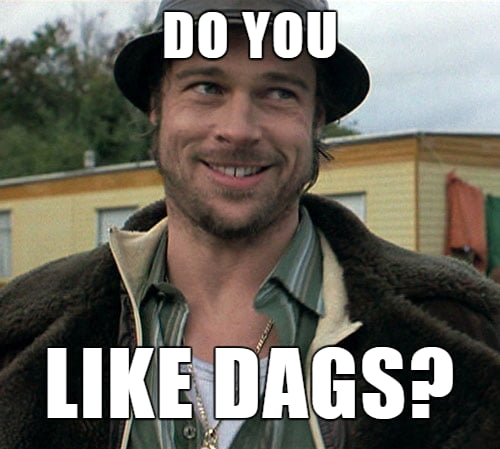

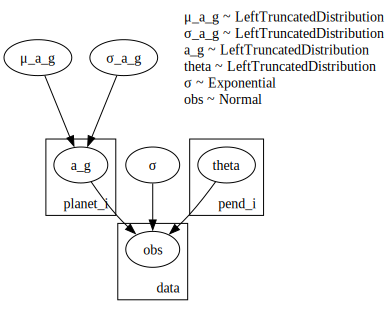

In [197]:
## first hierarchical
numpyro.render_model(
    model=hierarchical_model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

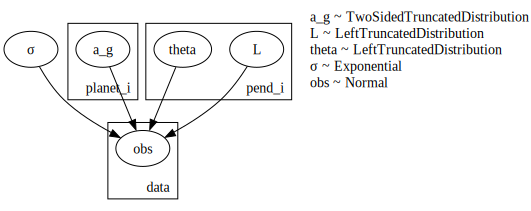

In [77]:
## unpooled
numpyro.render_model(
    model=unpooled_model,
    model_args=(planet_code, pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

## Prior predictive distribution
Before running anything, investigate what the prior predictive distribution looks like. This is a way of drawing from the priors that you have set up to see if they are reasonable compared to the data.

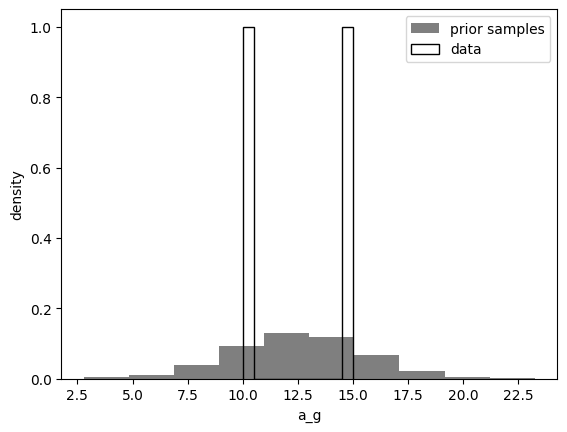

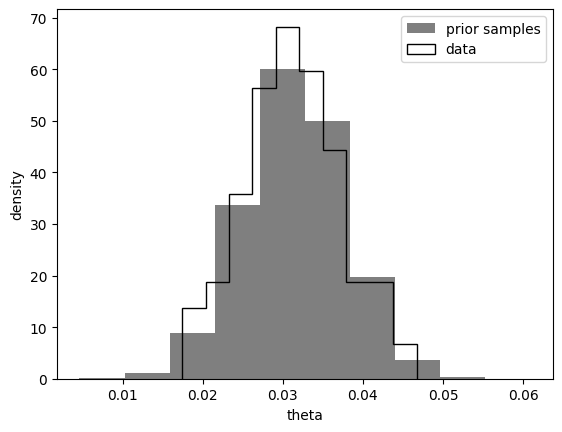

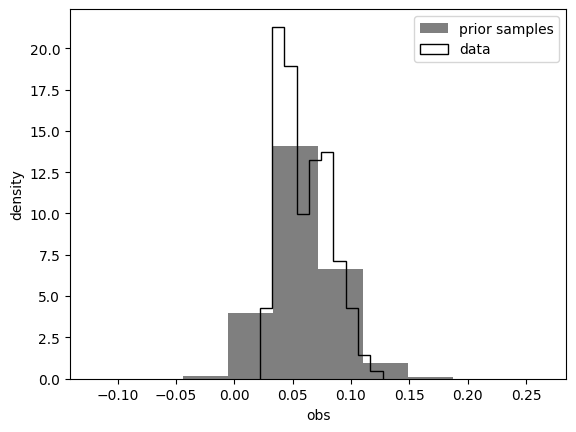

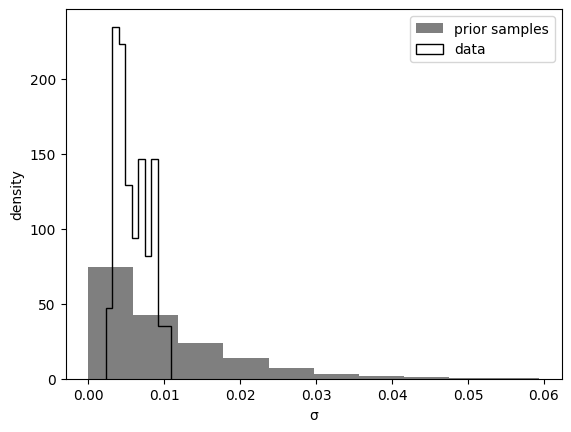

In [219]:
## generate samples from the prior using numpyro.infer.Predictive
## we will give it all the same inputs as the dataset, but this could be done with
## a new dataset

prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=1000)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
#plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "theta", "theta", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)


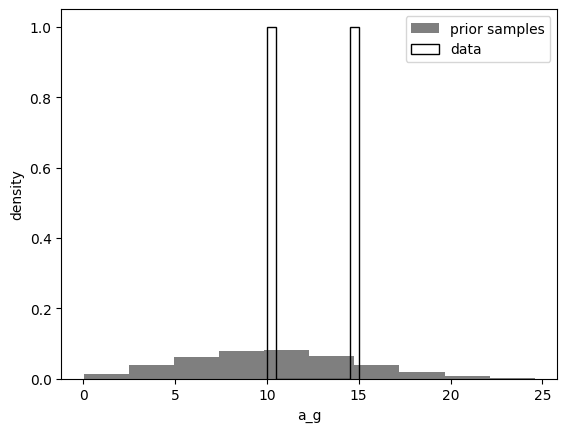

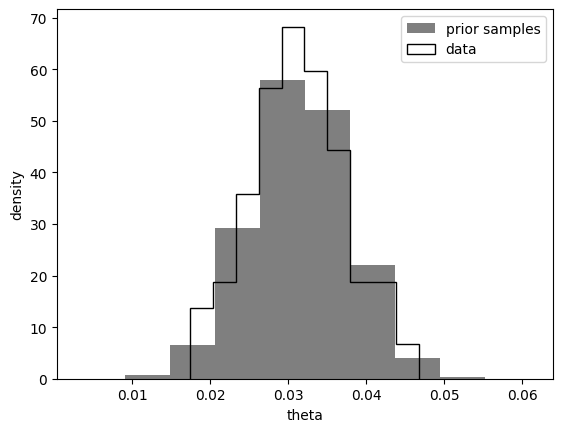

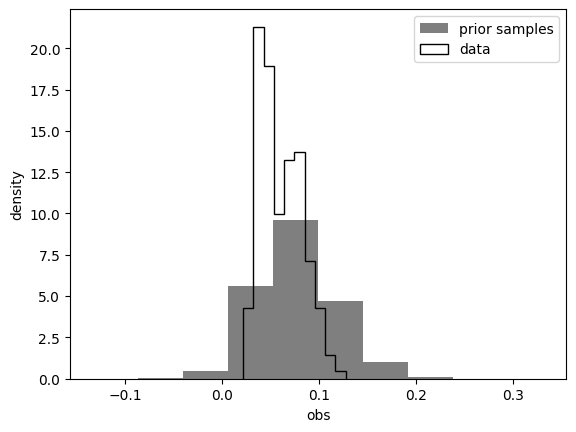

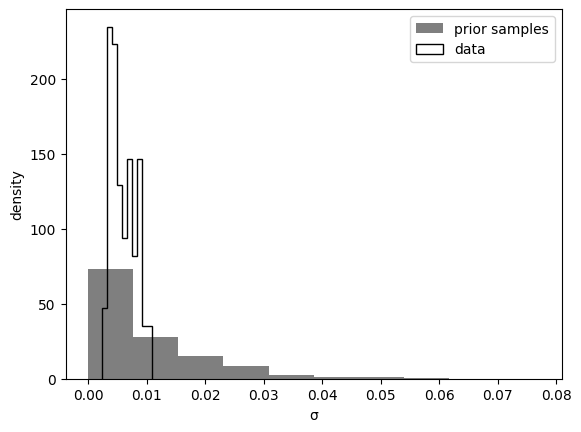

In [218]:
# same but for unpooled model

prior_pred = numpyro.infer.Predictive(unpooled_model, num_samples=1000)(
    random.PRNGKey(11), planet_code, pend_code, time_values
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
#plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "theta", "theta", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)



## Run the inference for the hierarchical case

In [220]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(hierarchical_model, init_strategy = numpyro.infer.initialization.init_to_sample)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc_hierarchical = MCMC(nuts_kernel, num_samples=5000, num_warmup=100, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_hierarchical.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)

posterior_samples_hierarchical = mcmc_hierarchical.get_samples()

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

In [200]:
## the arviz tools allows us to investigate the chain performance
inf_data = az.from_numpyro(mcmc_hierarchical)
## zero divergence means energy is conserved
print(f'divergences: {inf_data.sample_stats.diverging.values.sum()}')
az.summary(inf_data)

divergences: 635


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_g[0]       9.912  0.201   9.523   10.282      0.006    0.005     994.0   
a_g[1]      14.872  0.137  14.625   15.129      0.005    0.003     809.0   
theta[0]     0.024  0.001   0.021    0.026      0.000    0.000    4008.0   
theta[1]     0.033  0.001   0.030    0.035      0.000    0.000    4459.0   
theta[2]     0.034  0.001   0.031    0.037      0.000    0.000    4186.0   
...            ...    ...     ...      ...        ...      ...       ...   
theta[198]   0.029  0.002   0.025    0.034      0.000    0.000    6523.0   
theta[199]   0.021  0.002   0.017    0.026      0.000    0.000     514.0   
μ_a_g       12.477  1.216  10.145   14.694      0.032    0.023    1382.0   
σ            0.003  0.001   0.001    0.005      0.000    0.000      24.0   
σ_a_g        2.202  0.408   1.468    2.988      0.006    0.004    5656.0   

            ess_tail  r_hat  
a_g[0]        1735.0   1.01  
a_g[1]        3558.0   1.01  
theta[0]      2739.0   1.02  
theta[1]      3884.0   1.02  
theta[2]      3746.0   1.03  
...              ...    ...  
theta[198]    3058.0   1.01  
theta[199]    1687.0   1.01  
μ_a_g         6319.0   1.00  
σ               16.0   1.13  
σ_a_g         9215.0   1.00  

[205 rows x 9 columns]

A few things to check here - you want to look at the effective sample size (ess_bulk and ess_tail). This number tells you how many HMC samples are independent; you want this number to close to the total number of samples.

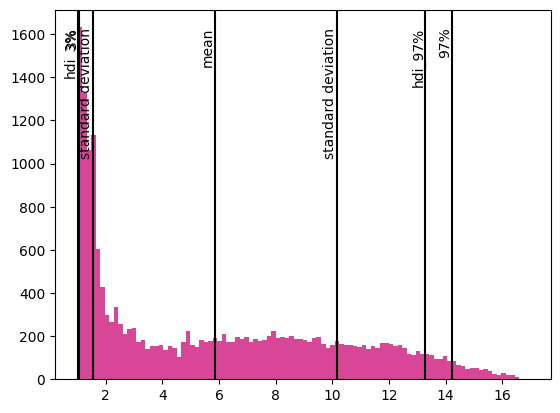

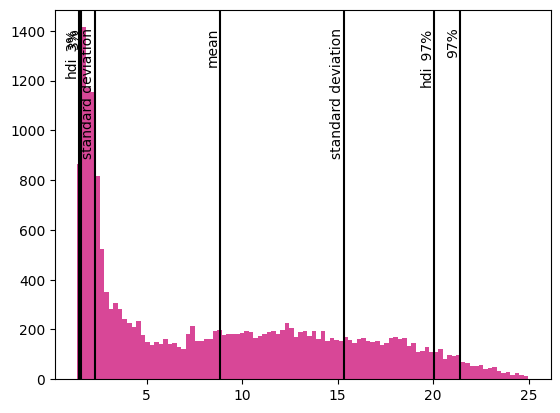

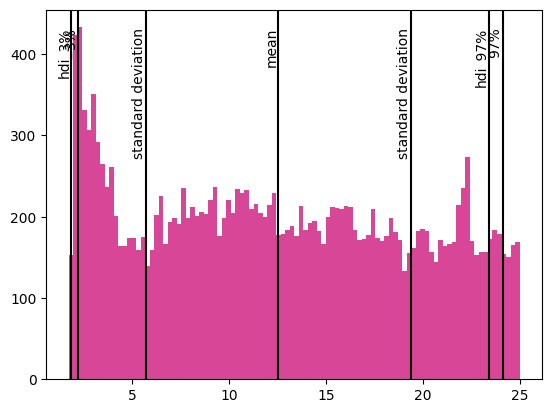

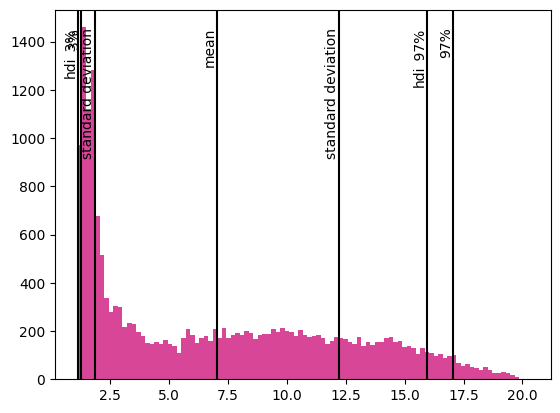

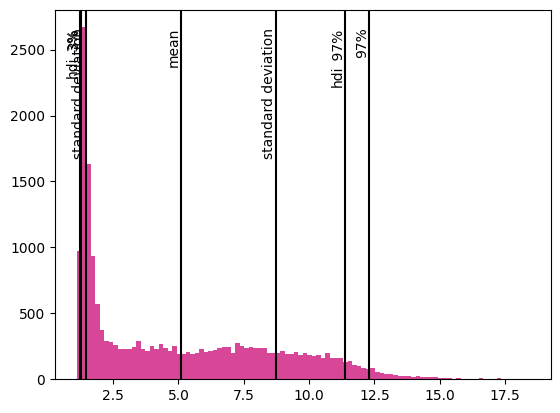

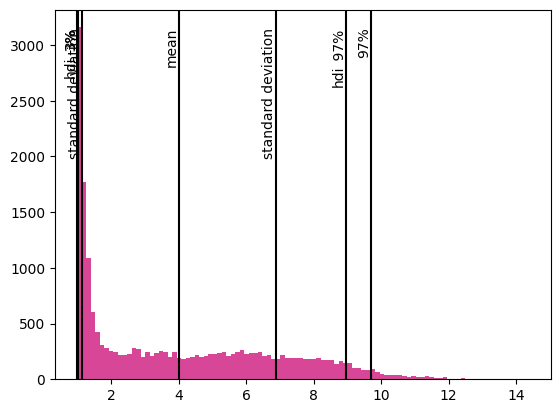

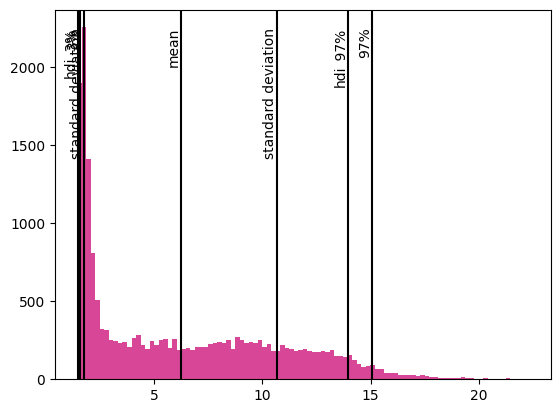

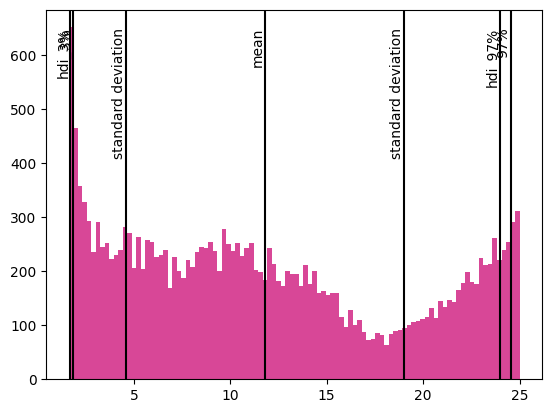

In [19]:
investigate_distribution_posteriors(posterior_samples_hierarchical, inf_data)

## Interpreting the arviz table
The first two columns are the mean and standard deviation of each parameter, taken from examining all four chains.

- hdi = the high density interval, which is the minimum width Bayesian credible interval (BCI)

The best description I've found for it:

The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. In contrast, a symmetric density interval defined by (eg.) the 10% and 90% quantiles may include values with lower probability than those excluded.


- mcse = markov chain standard error

- ess = effective sample size

This is equal to the sample size if all samples are independent. Here, the values are quite low for the different parameters, which indicates that we have very few indpendent draws. Does this mean we need to length the chains? Maybe.

- rhat = rank normalized splitR-hat for a set of traces (https://arxiv.org/pdf/1903.08008.pdf)

The rank normalized R-hat diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.

rhat ~ sqrt(1 + Nchains/ESS), 


so ESS/Nchains ~ 1/2/(rhat - 1), which means that if rhat = 1.05 then ESS/Nchains = 10, which isn’t very big

<Figure size 640x480 with 0 Axes>

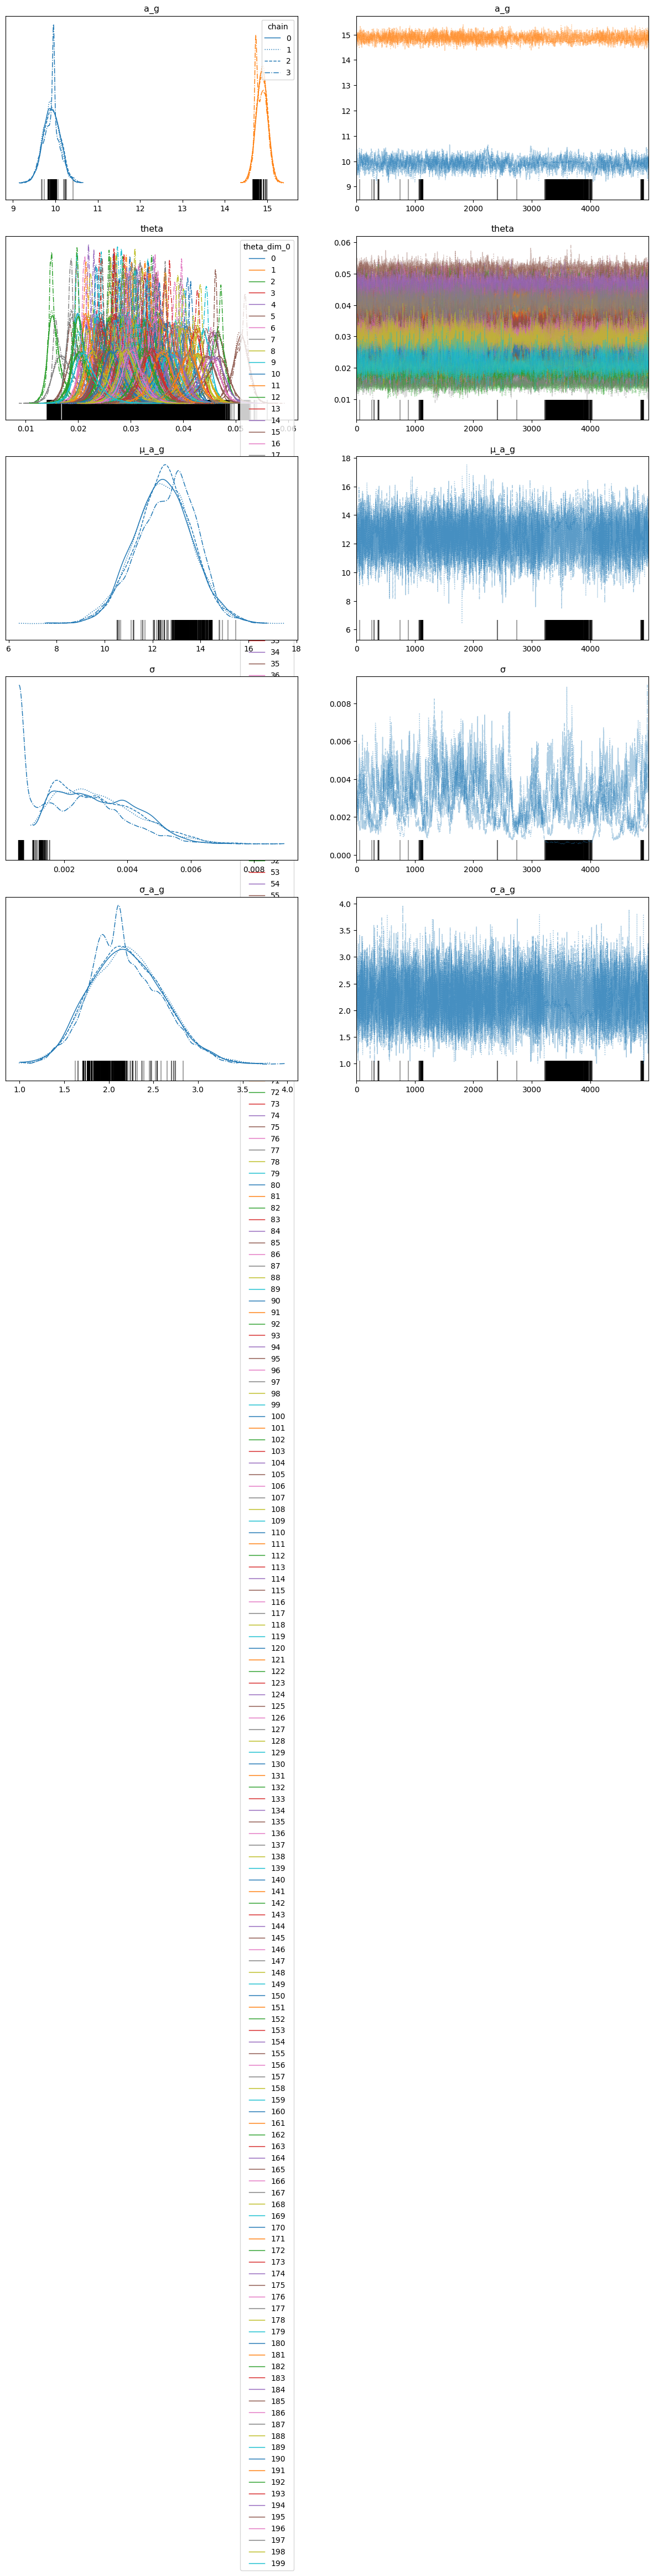

In [201]:
data = az.from_numpyro(mcmc_hierarchical)
plt.clf()
az.plot_trace(data, compact=True, figsize=(15, 25), legend=True)
plt.show()

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [126]:
# so there are sampler chains for each group
print('shape of L samples', np.shape(mcmc_hierarchical.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc_hierarchical.get_samples()['a_g']))

shape of L samples (20000, 8)
shape of a_g samples (20000, 2)


In [167]:
# take a look at the posterior
make_corner_plots(posterior_samples_hierarchical, data_params)

KeyError: 'L'

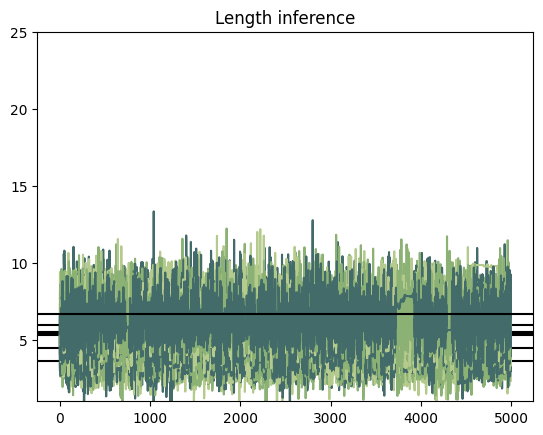

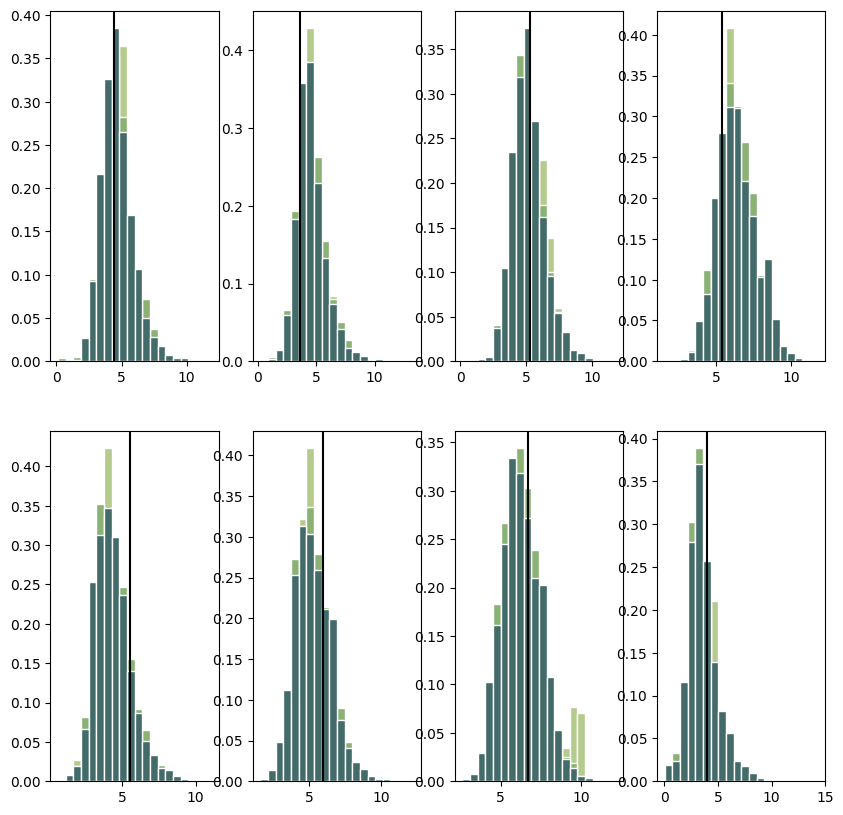

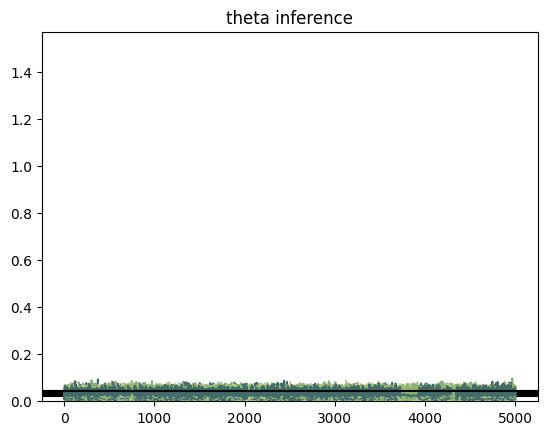

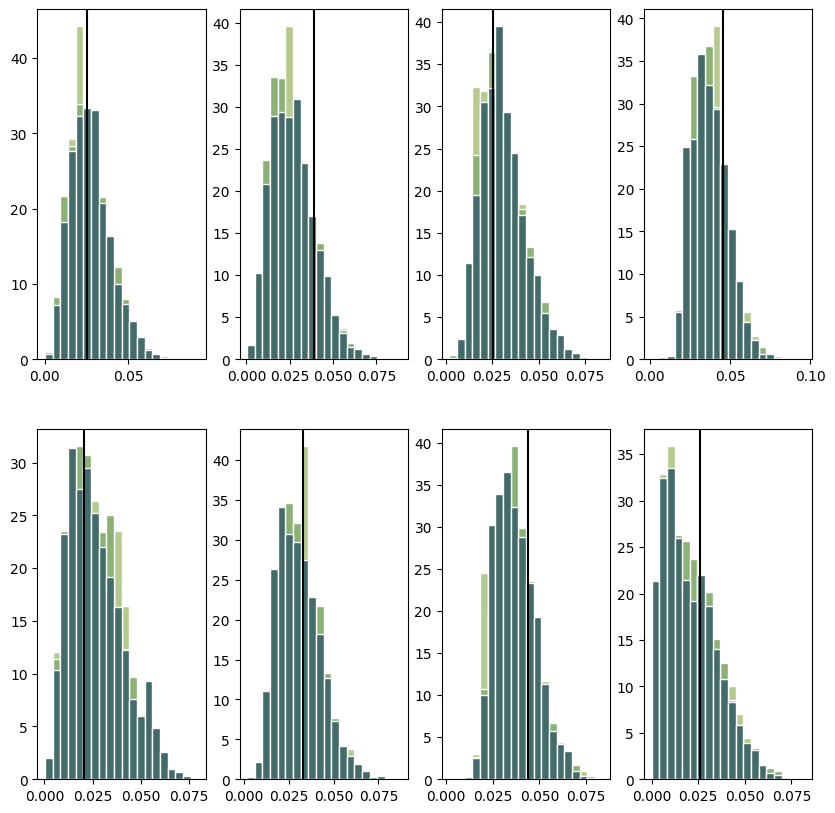

In [42]:
# Let's come up with a better way to show all seven pendulums sampling result in histogram form
# for the separate 4 chains
#def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):

examine_chains(posterior_hierarchical, data_params)


In [43]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)
how_did_we_do_on_all_pendulums(df, posterior_hierarchical, 8, 2000)

NameError: name 'times' is not defined

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

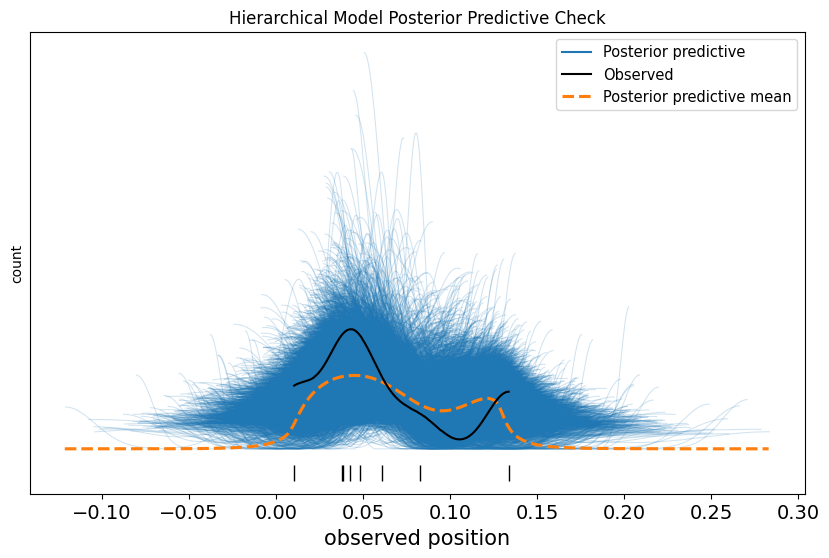

In [128]:
# plot the posterior predictive samples
# get posterior predictive samples

hierarachical_posterior_predictive, hierarchical_posterior_predictive_samples, hierarchical_idata = plot_posterior_predictive_samples(df,
                                  hierarchical_model,
                                  posterior_hierarchical,
                                  rng_key,
                                  time_values,
                                  mcmc_hierarchical,
                                  pooled = False,
                                  title = "Hierarchical Model Posterior Predictive Check")

In [ ]:
# plot for each individual planet
print(hierarachical_posterior_predictive)
print(hierarchical_posterior_predictive_samples)
print(np.shape(posterior_hierarchical['L'][:,0]))


nbins = 20

plt.clf()
value, bin_center = np.histogram(hierarchical_posterior_predictive_samples['obs'].flatten()[:], bins = nbins)
plt.hist(hierarchical_posterior_predictive_samples['obs'].flatten()[:],
         bins = bin_center,
         color = '#6C969D', alpha = 0.5,
         label = 'Model posterior', 
         density = True,
         histtype='bar', ec='white')
plt.hist(df["pos"].values,
         bins = bin_center,
         color = '#99D5C9', alpha = 0.5,
         label = 'Obs',
         density = True,
         histtype='bar', ec='white')
plt.legend()
plt.show()

STOP
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for location in range(1, 2 + 1):
    ax = axes[location - 1]
    sns.histplot(
        x=hierarchical_posterior_predictive_samples["a_g"][:, location - 1],
        color=f"C{location - 1}",
        ax=ax,
    )
    ax.set(title=f"Planet {location}", xlabel="a_g", ylabel="count")

fig.suptitle("Hierarchical Model Prior Predictive Samples", y=1.05, fontsize=16)

## Now run the inference for the unpooled case

In [221]:
# higher acceptance means smaller step size
# Target acceptance probability for step size adaptation using Dual Averaging. 
# Increasing this value will lead to a smaller step size, hence the sampling will be slower but more robust.
# Defaults to 0.8.
nuts_kernel_unpooled = NUTS(unpooled_model, init_strategy = numpyro.infer.initialization.init_to_sample)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=5000, num_warmup=100, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_unpooled.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)

posterior_samples_unpooled = mcmc_unpooled.get_samples()

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

  0%|          | 0/5100 [00:00<?, ?it/s]

In [203]:
inf_data_unpooled = az.from_numpyro(mcmc_unpooled)
az.summary(inf_data_unpooled)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]        4.507  1.197   2.821    6.835      0.088    0.062     112.0   
L[1]        5.274  1.377   3.255    8.120      0.201    0.149      70.0   
L[2]        5.146  1.125   3.317    7.397      0.039    0.027     847.0   
L[3]        4.774  1.208   2.850    6.969      0.091    0.065     261.0   
L[4]        5.503  1.314   3.486    8.128      0.147    0.111     107.0   
...           ...    ...     ...      ...        ...      ...       ...   
theta[196]  0.028  0.012   0.008    0.051      0.001    0.001     250.0   
theta[197]  0.030  0.013   0.010    0.052      0.001    0.001      63.0   
theta[198]  0.028  0.012   0.009    0.053      0.001    0.001     413.0   
theta[199]  0.025  0.013   0.005    0.048      0.001    0.001     186.0   
σ           0.006  0.003   0.002    0.013      0.001    0.001      17.0   

            ess_tail  r_hat  
L[0]           312.0   1.03  
L[1]            45.0   1.04  
L[2]           758.0   1.02  
L[3]          3744.0   1.02  
L[4]           133.0   1.04  
...              ...    ...  
theta[196]     398.0   1.02  
theta[197]      52.0   1.06  
theta[198]     377.0   1.02  
theta[199]    2681.0   1.02  
σ               33.0   1.19  

[403 rows x 9 columns]

<Figure size 640x480 with 0 Axes>

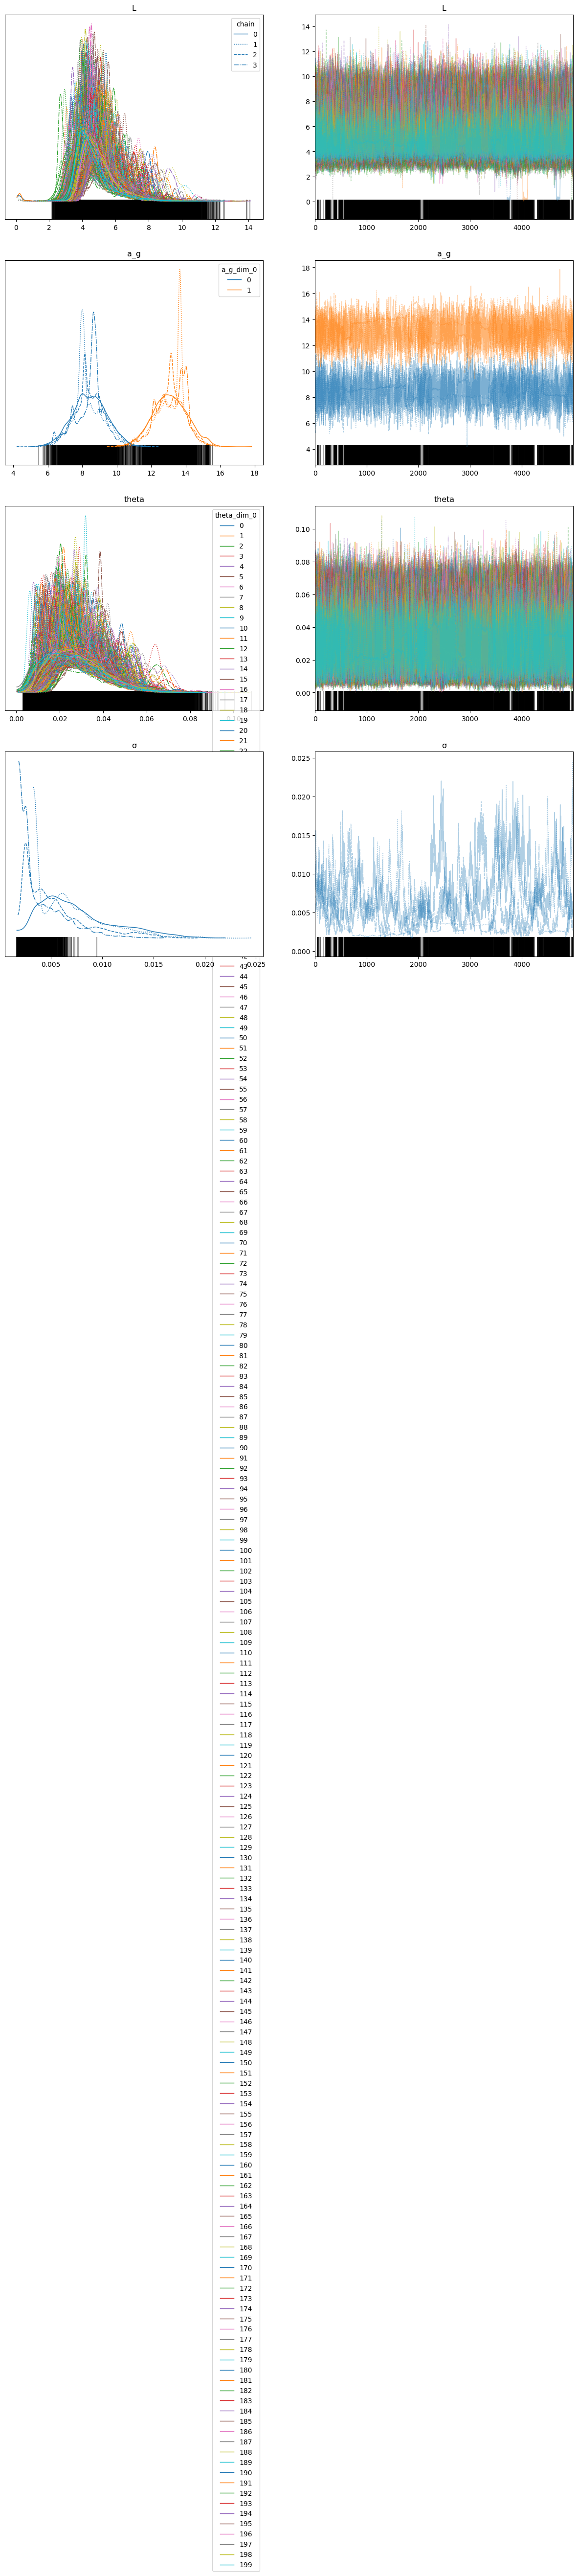

In [204]:
data_unpooled = az.from_numpyro(mcmc_unpooled)
plt.clf()
az.plot_trace(data_unpooled, compact=True, figsize=(15, 25), legend=True)
plt.show()

<Figure size 640x480 with 0 Axes>

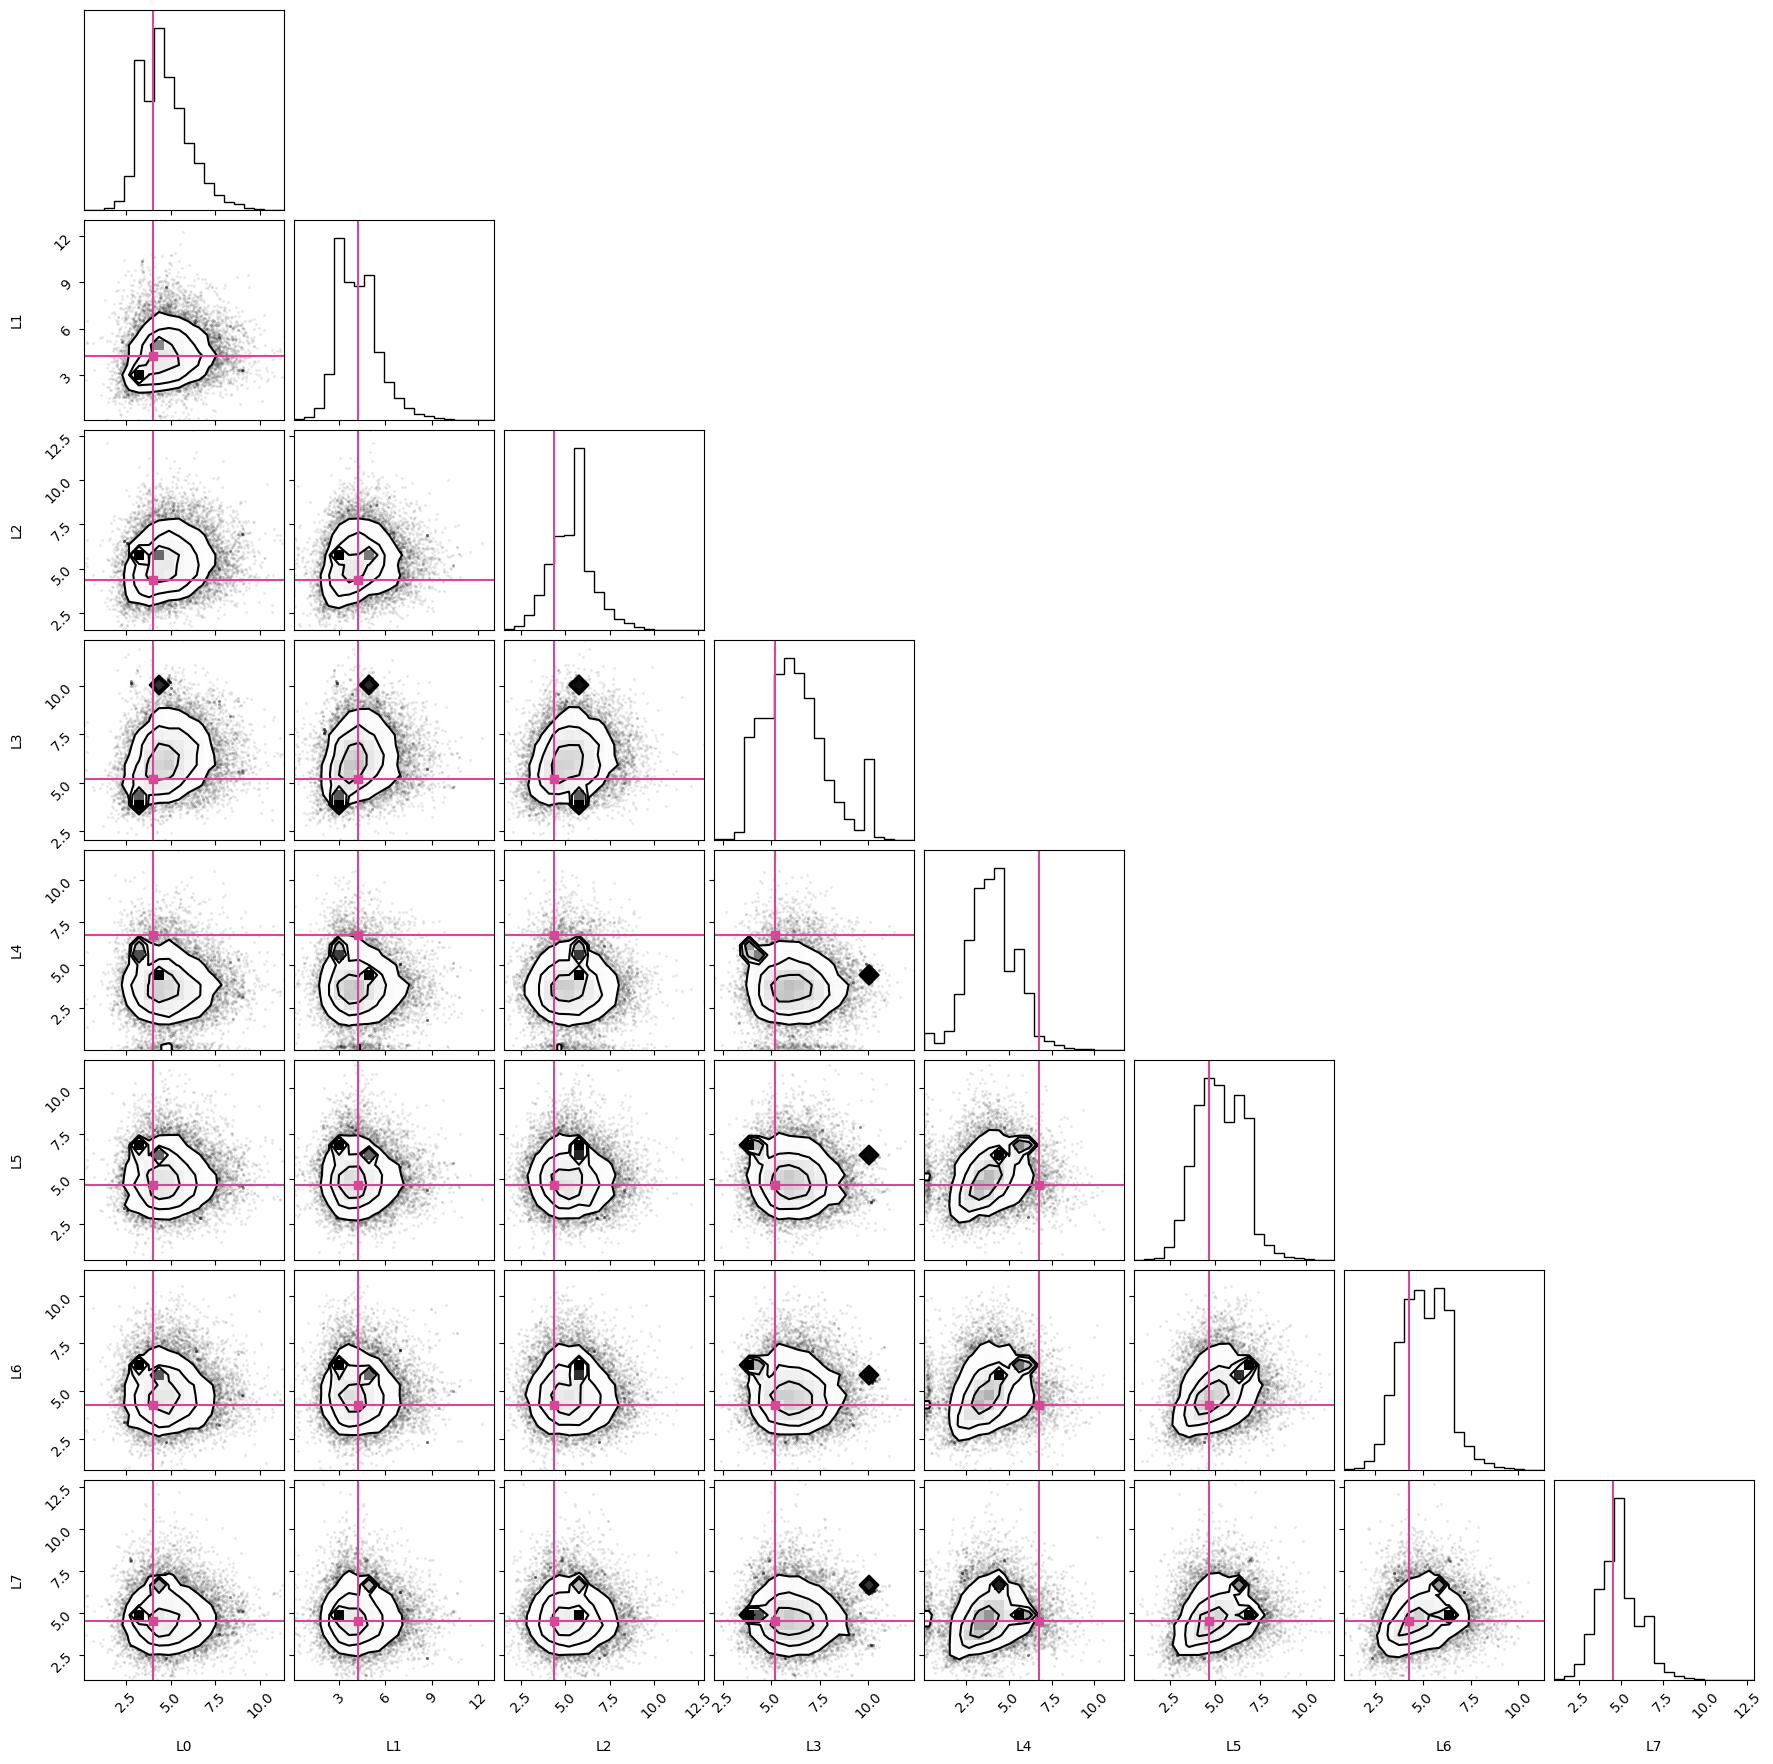

<Figure size 640x480 with 0 Axes>

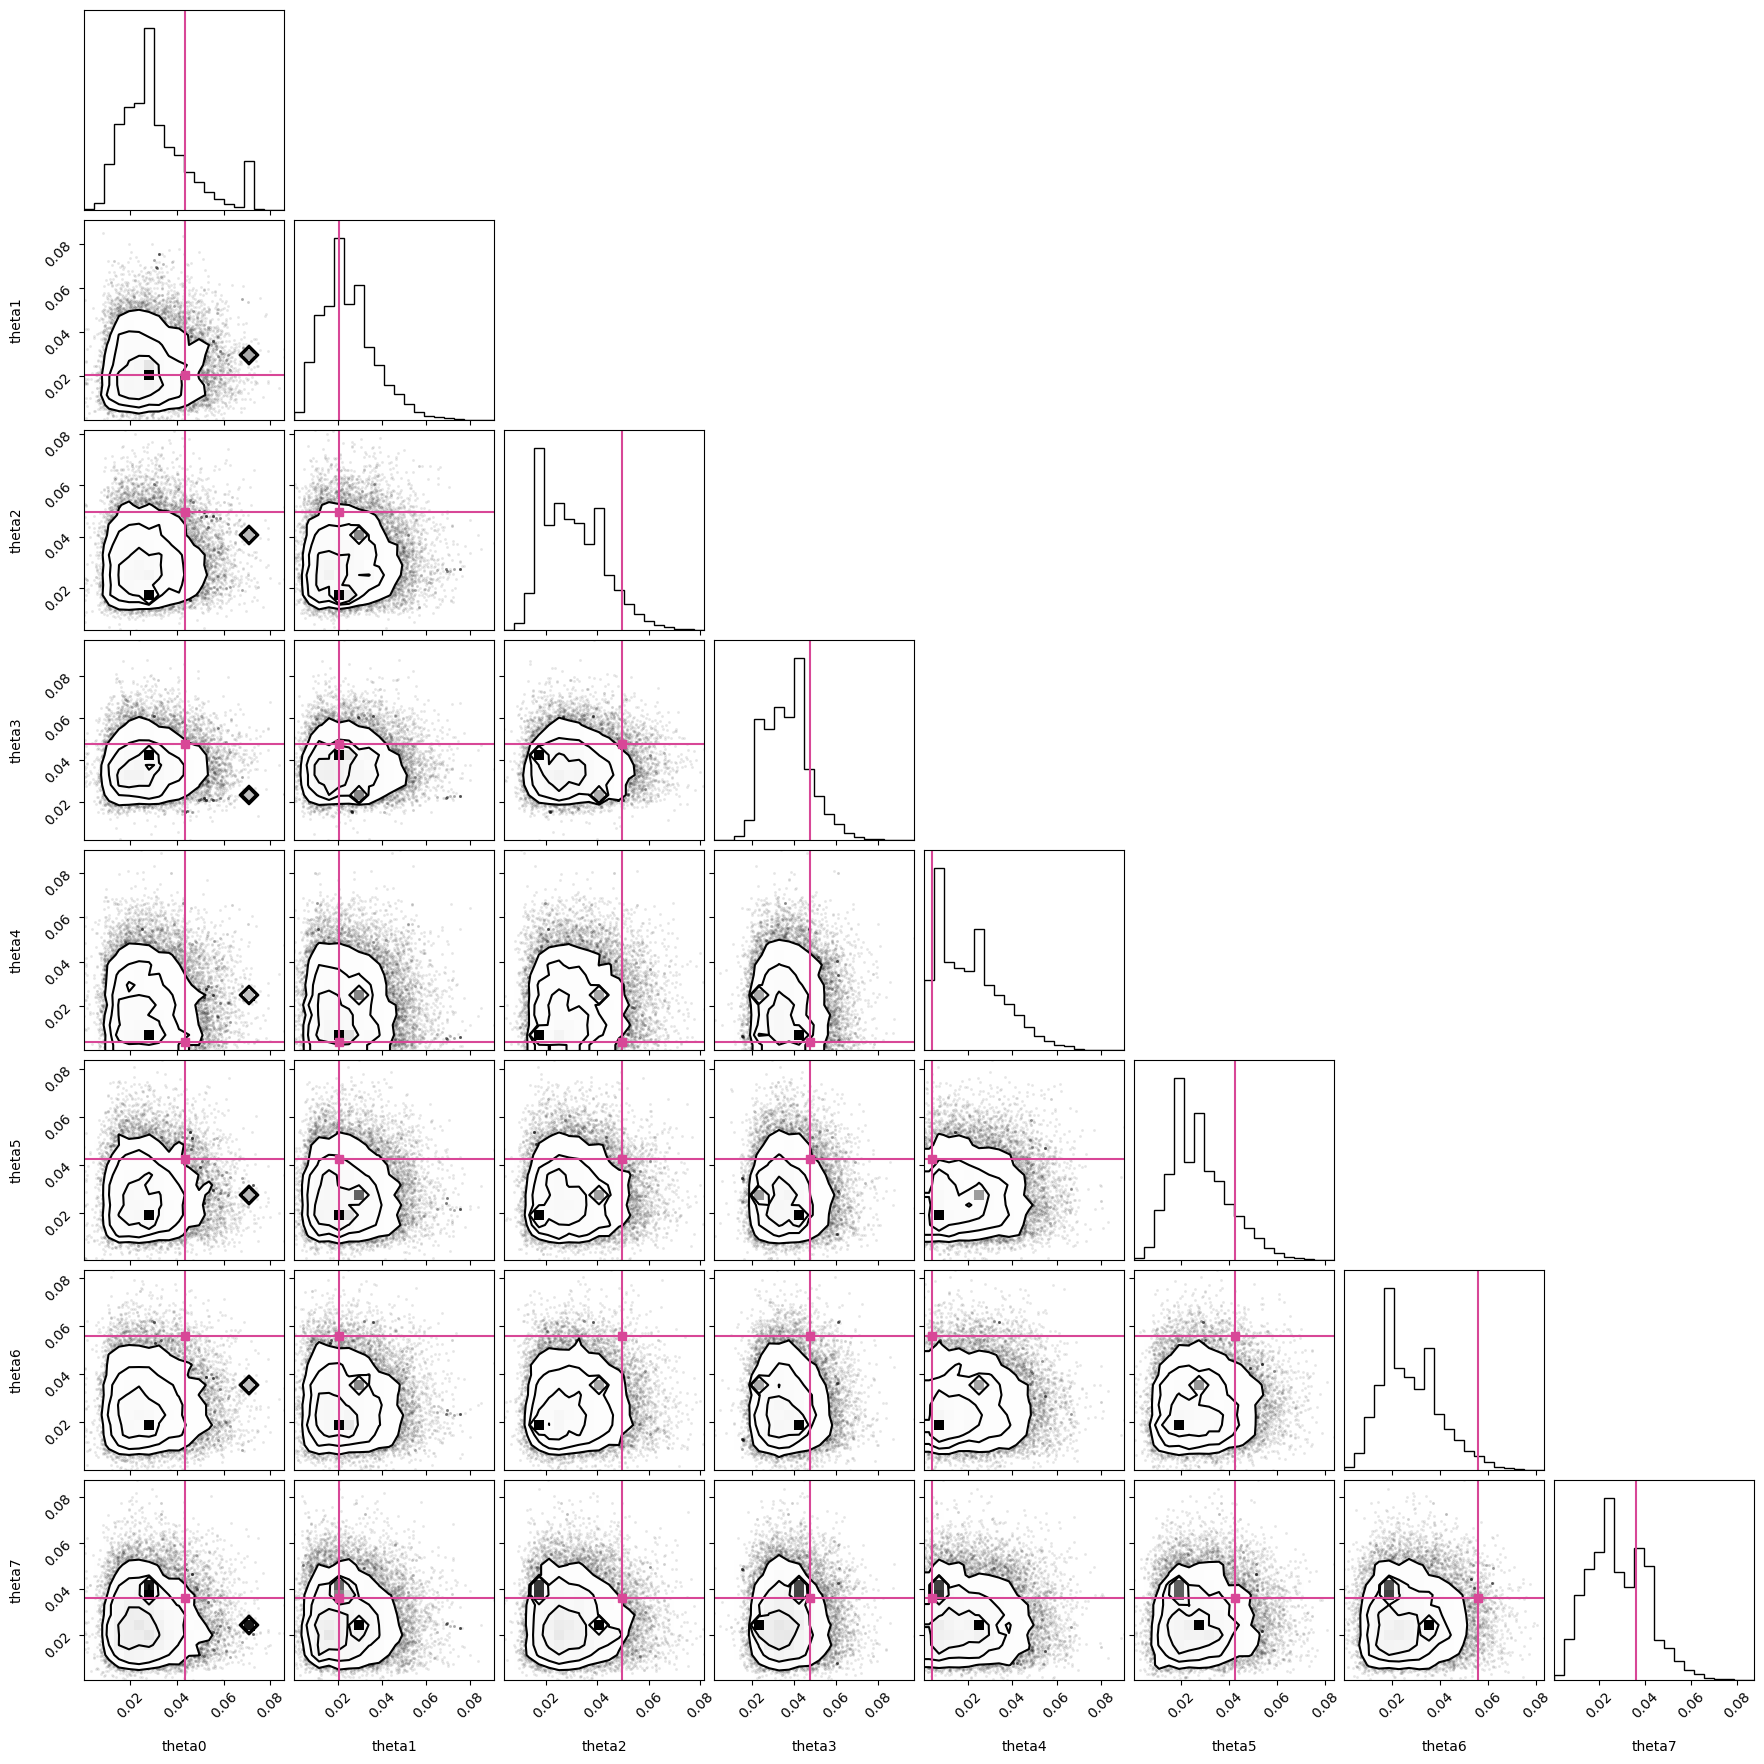

[10. 10. 10. 10. 15. 15. 15. 15.]


<Figure size 640x480 with 0 Axes>

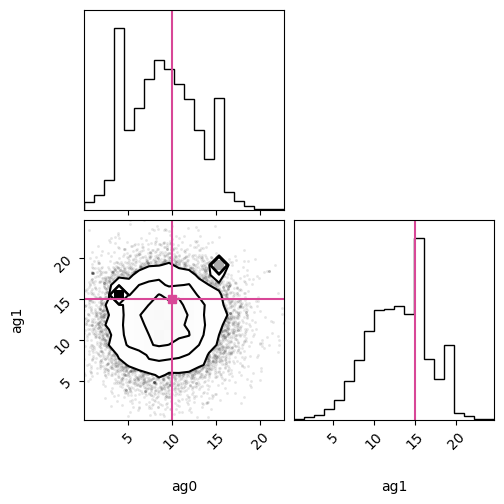

<Figure size 640x480 with 0 Axes>

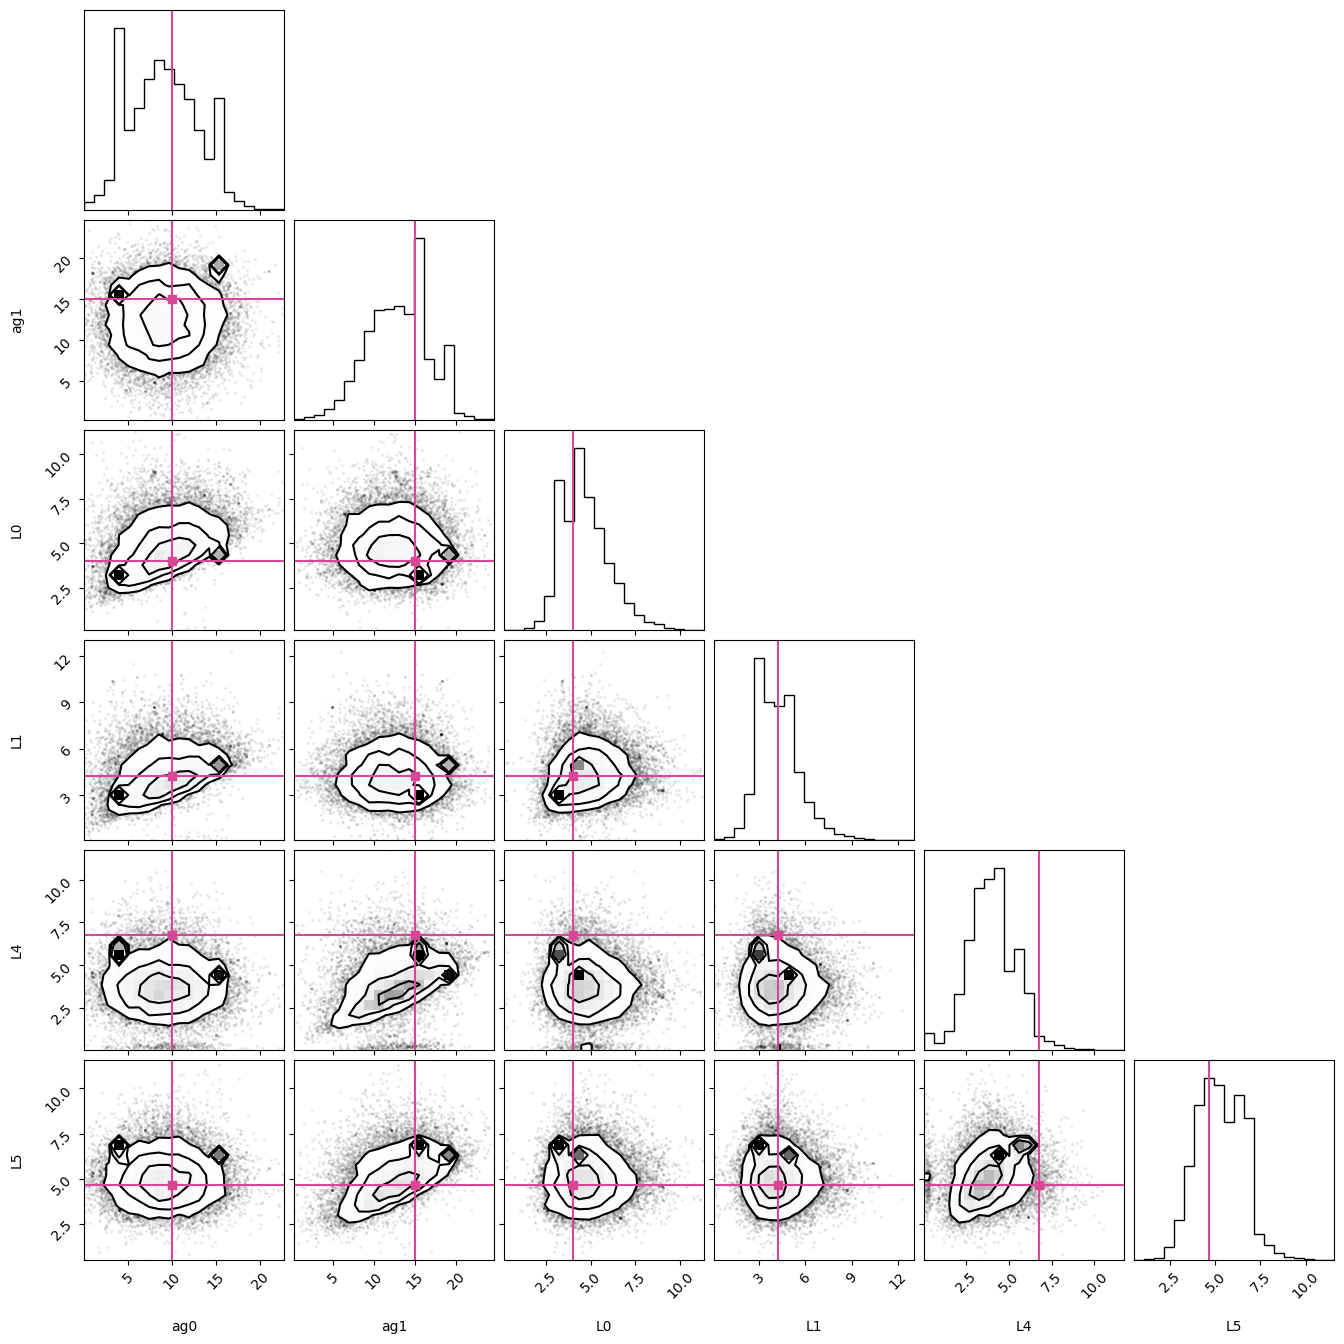

In [132]:
# take a look at the posterior
make_corner_plots(posterior_samples_unpooled, data_params)

## Lets compare the two models

One way to do comparisons is to look at the chains for each parameter.

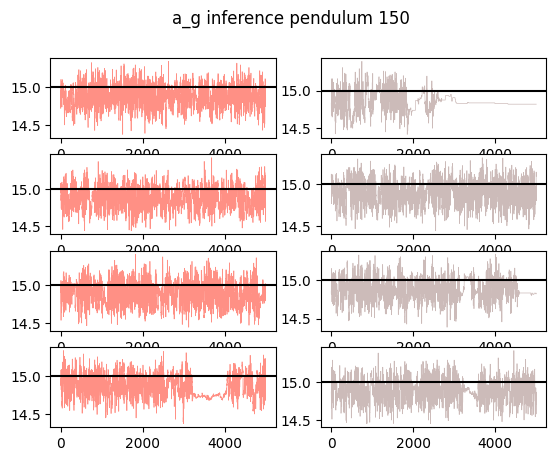

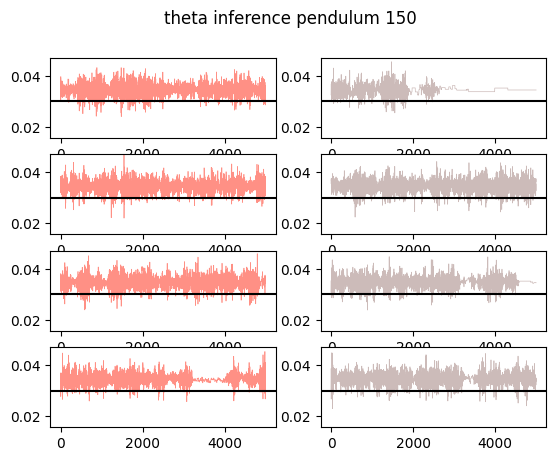

In [236]:
n_pendulums = 8
n_chains = 4
chain_length = 5000

fig, axs = plt.subplots(4, 2)

p = 150
for chain in range(n_chains):
    ax = axs[chain,0]
    
    ax.plot(posterior_samples_hierarchical['a_g'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} hierarchical', alpha = 0.5, lw = 0.5,
             color = '#FF220C', 
)
    ax.axhline(y = data_params['a_g'][p], color = 'black')
    #ax.set_ylim([7,12])


    ax = axs[chain,1]
    
    ax.plot(posterior_samples_unpooled['a_g'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} unpooled', alpha = 0.5, lw = 0.5,
             color = '#9B7874', 
)
    #break
    ax.axhline(y = data_params['a_g'][p], color = 'black')
    #ax.set_ylim([7,12])

    
fig.suptitle(f'a_g inference pendulum {p}')
#plt.legend()
plt.show()

fig, axs = plt.subplots(4, 2)


for chain in range(n_chains):
    ax = axs[chain,0]
    
    ax.plot(posterior_samples_hierarchical['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} hierarchical', alpha = 0.5, lw = 0.5,
             color = '#FF220C', 
)
    ax.axhline(y = data_params['theta'][p], color = 'black')
    ax.set_ylim([1*jnp.pi/200, 3*jnp.pi/200])


    ax = axs[chain,1]
    
    ax.plot(posterior_samples_unpooled['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
             label = f'chain {chain} unpooled', alpha = 0.5, lw = 0.5,
             color = '#9B7874', 
)
    #break
    ax.axhline(y = data_params['theta'][p], color = 'black')
    ax.set_ylim([1*jnp.pi/200, 3*jnp.pi/200])

fig.suptitle(f'theta inference pendulum {p}')
#plt.legend()
plt.show()

My interpretation is that the chains are offset for many of the parameters.

In [52]:
# What is a posterior predictive check?
# comparing the cumulative x positions from the data to those generated from 
# the posterior distribution
# some say this is using the data twice - 1. to generate the thetas, 2. to check again
compare_models(unpooled_idata, unpooled_idata, hierarchical_idata, kind = 'cumulative')

NameError: name 'unpooled_idata' is not defined

<Figure size 640x480 with 0 Axes>

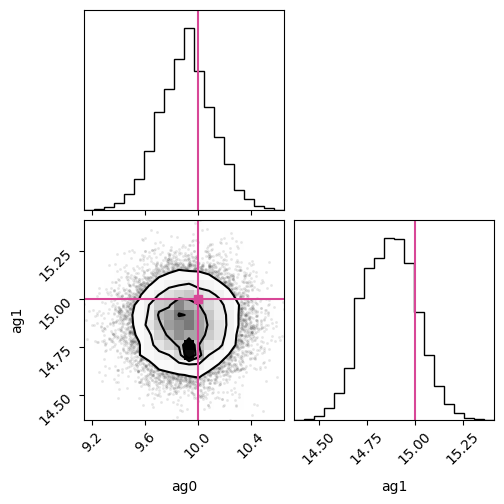

<Figure size 640x480 with 0 Axes>

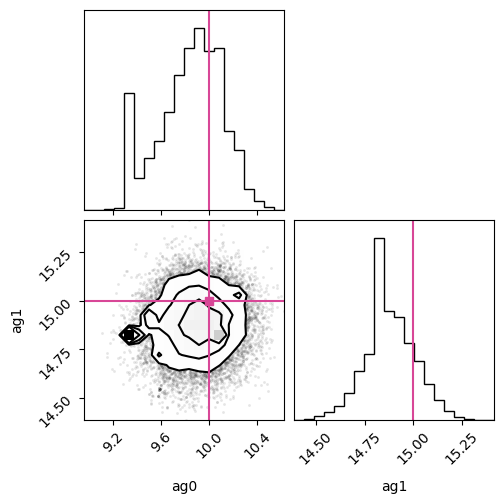

In [267]:
data = az.from_dict(
            posterior={"ag0": posterior_samples_hierarchical["a_g"][:,0], "ag1": posterior_samples_hierarchical["a_g"][:,1],
                       #"L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                       #"L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                       #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                       },
            #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
)
plt.clf()
figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][-1]], truth_color = '#D84797')
plt.show()

data = az.from_dict(
            posterior={"ag0": posterior_samples_unpooled["a_g"][:,0], "ag1": posterior_samples_unpooled["a_g"][:,1],
                       #"L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                       #"L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                       #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                       },
            #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
)
plt.clf()
figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][-1]], truth_color = '#D84797')
plt.show()

Comparing the posterior distributions of $a_g$ for the two groupings (planets); let's look at the 1D ones

(20000, 2)


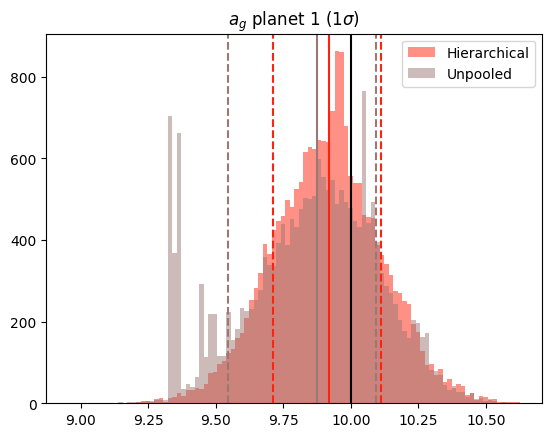

In [268]:
print(np.shape(posterior_samples_unpooled['a_g']))
'''
p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
'''
xbins, bins = np.histogram(posterior_samples_unpooled['a_g'][:,0], bins = 100)
plt.hist(posterior_samples_hierarchical['a_g'][:,0], alpha = 0.5,
         label = 'Hierarchical', color = '#FF220C',
         bins = bins)
plt.hist(posterior_samples_unpooled['a_g'][:,0], alpha = 0.5,
         label = 'Unpooled', color = '#9B7874',
         bins = bins)

plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,0], 50), color = '#FF220C')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,0], 15.9), color = '#FF220C', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,0], 84.1), color = '#FF220C', ls = '--')


plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,0], 50), color = '#9B7874')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,0], 15.9), color = '#9B7874', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,0], 84.1), color = '#9B7874', ls = '--')


plt.axvline(x = 10.0, color = 'black')
plt.legend()
plt.title('$a_g$ planet 1 (1$\sigma$)')
plt.show()

(20000, 2)
[14.83350579 14.76443252 14.72144096 ... 14.86767948 14.70658074
 14.88052016] 14.86616661147356 14.878783090397215


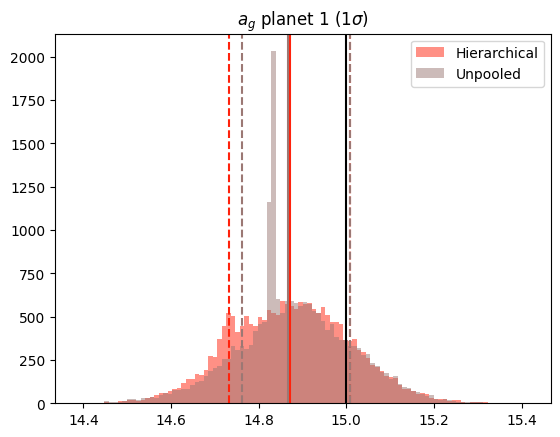

In [269]:
print(np.shape(posterior_samples_unpooled['a_g']))
print(posterior_samples_unpooled['a_g'][:,1],
      np.percentile(posterior_samples_unpooled['a_g'][:,1], 50),
      np.mean(posterior_samples_unpooled['a_g'][:,1]))

'''
p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
'''
xbins, bins = np.histogram(posterior_samples_unpooled['a_g'][:,1], bins = 100)
plt.hist(posterior_samples_hierarchical['a_g'][:,1], alpha = 0.5,
         label = 'Hierarchical', color = '#FF220C',
         bins = bins)
plt.hist(posterior_samples_unpooled['a_g'][:,1], alpha = 0.5,
         label = 'Unpooled', color = '#9B7874',
         bins = bins)

plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,1], 50), color = '#FF220C')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,1], 15.9), color = '#FF220C', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_hierarchical['a_g'][:,1], 84.1), color = '#FF220C', ls = '--')


plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,1], 50), color = '#9B7874')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,1], 15.9), color = '#9B7874', ls = '--')
plt.axvline(x = np.percentile(posterior_samples_unpooled['a_g'][:,1], 84.1), color = '#9B7874', ls = '--')


plt.axvline(x = 15.0, color = 'black')
plt.legend()
plt.title('$a_g$ planet 1 (1$\sigma$)')
plt.show()

Okay but how does this compare to the expected error?

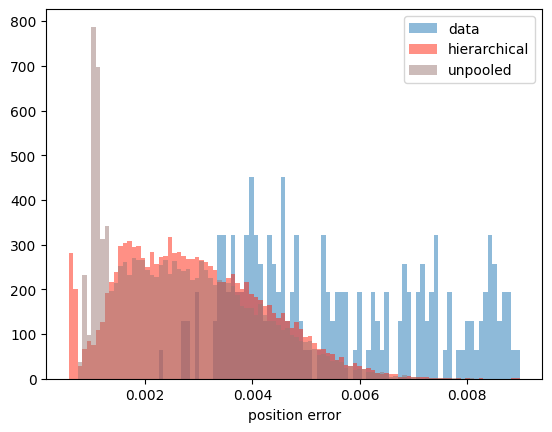

In [270]:
xbins, bins = np.histogram(posterior_samples_hierarchical['σ'], bins = 100)


plt.hist(df['pos_err'].values, bins = bins, alpha = 0.5, density = True, label = 'data')
plt.hist(posterior_samples_hierarchical['σ'], bins = bins, alpha = 0.5, color = '#FF220C', density = True, label = 'hierarchical')
plt.hist(posterior_samples_unpooled['σ'], bins = bins, alpha = 0.5, color = '#9B7874', density = True, label = 'unpooled')
plt.xlabel('position error')
plt.legend();

# But how to compare the modeled positions to the true positions?
This is like a PPC but I want to do it by hand.

First I'll construct a df for each model.

In [273]:
df_hierarchical = pd.DataFrame()
df_unpooled = pd.DataFrame()

df_hierarchical['L'] = np.repeat(5.0, len(df))
df_unpooled['L'] = np.repeat(5.0, len(df))

df_hierarchical['theta'] = np.percentile(posterior_samples_hierarchical['theta'],50, axis = 0)
df_unpooled['theta'] = np.percentile(posterior_samples_unpooled['theta'],50, axis = 0)

percentile_50_0 = np.percentile(posterior_samples_hierarchical['a_g'][:, 0], 50)
percentile_50_1 = np.percentile(posterior_samples_hierarchical['a_g'][:, 1], 50)

# Assign percentiles to specific elements of df_hierarchical['a_g']
index_half_len = len(df_hierarchical) // 2
df_hierarchical['a_g'] = percentile_50_0
df_hierarchical['a_g'][index_half_len:] = percentile_50_1

percentile_50_0 = np.percentile(posterior_samples_unpooled['a_g'][:, 0], 50)
percentile_50_1 = np.percentile(posterior_samples_unpooled['a_g'][:, 1], 50)

# Assign percentiles to specific elements of df_hierarchical['a_g']
index_half_len = len(df_unpooled) // 2
df_unpooled['a_g'] = percentile_50_0
df_unpooled['a_g'][index_half_len:] = percentile_50_1

#df_hierarchical['a_g'][:,len(df)/2 - 1] = np.percentile(posterior_samples_hierarchical['a_g'][:,0],50)
#df_hierarchical['a_g'][len(df)/2 - 1:-1] = np.percentile(posterior_samples_hierarchical['a_g'][:,1],50)

df_hierarchical['pos'] = df_hierarchical['L'].values * jnp.sin(df_hierarchical['theta'].values * \
                                                        jnp.cos(jnp.sqrt(df_hierarchical['a_g'].values / df_hierarchical['L'].values) * 0.75))

df_unpooled['pos'] = df_unpooled['L'].values * jnp.sin(df_unpooled['theta'].values * \
                                                        jnp.cos(jnp.sqrt(df_unpooled['a_g'].values / df_unpooled['L'].values) * 0.75))

df_hierarchical['pos_err'] = np.percentile(posterior_samples_hierarchical['σ'],50, axis = 0)
df_unpooled['pos_err'] = np.percentile(posterior_samples_unpooled['σ'],50, axis = 0)

print(df_hierarchical)
print(df_unpooled)

       L     theta        a_g       pos   pos_err
0    5.0  0.023541   9.917398  0.057924  0.002781
1    5.0  0.032546   9.917398  0.080080  0.002781
2    5.0  0.033896   9.917398  0.083401  0.002781
3    5.0  0.024077   9.917398  0.059242  0.002781
4    5.0  0.035069   9.917398  0.086288  0.002781
..   ...       ...        ...       ...       ...
195  5.0  0.033488  14.872362  0.045838  0.002781
196  5.0  0.030247  14.872362  0.041402  0.002781
197  5.0  0.040604  14.872362  0.055577  0.002781
198  5.0  0.029277  14.872362  0.040073  0.002781
199  5.0  0.021131  14.872362  0.028924  0.002781

[200 rows x 5 columns]
       L     theta        a_g       pos   pos_err
0    5.0  0.023404   9.874889  0.057817  0.002517
1    5.0  0.032338   9.874889  0.079887  0.002517
2    5.0  0.033667   9.874889  0.083170  0.002517
3    5.0  0.023912   9.874889  0.059073  0.002517
4    5.0  0.034847   9.874889  0.086085  0.002517
..   ...       ...        ...       ...       ...
195  5.0  0.033483  14.866

First thing to do is examine the true position compared to the estimated position and pos err.

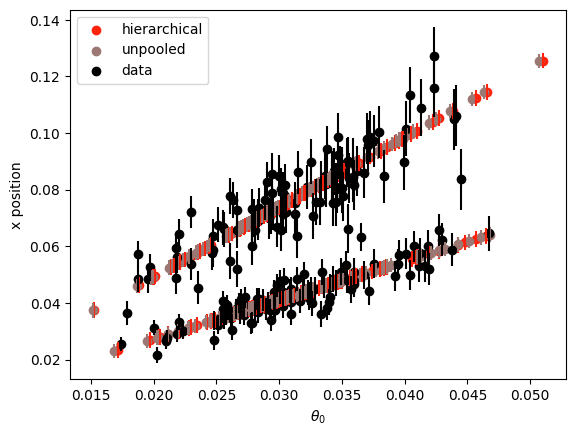

In [283]:
plt.clf()
plt.scatter(df_hierarchical['theta'].values, 
            df_hierarchical['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.errorbar(df_hierarchical['theta'].values, 
            df_hierarchical['pos'].values,
            yerr = df_hierarchical['pos_err'].values,
            color = '#FF220C',
            ls = 'None')
plt.scatter(df_unpooled['theta'].values, 
            df_unpooled['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.errorbar(df_unpooled['theta'].values, 
            df_unpooled['pos'].values,
            yerr = df_unpooled['pos_err'].values,
            color = '#9B7874',
            ls = 'None')
plt.scatter(df['theta'].values,
            df['pos'].values,
            color = 'black',
            label = 'data')
plt.errorbar(df['theta'].values,
            df['pos'].values,
            yerr = df['pos_err'].values,
            color = 'black',
            ls = 'None')
plt.xlabel(r'$\theta_0$')
plt.ylabel('x position')
plt.legend()
plt.show()

Both models are essentially estimating the mean of both $a_g$ populations. Let's get a better idea by looking at the residuals of observed x position and the predicted x position.

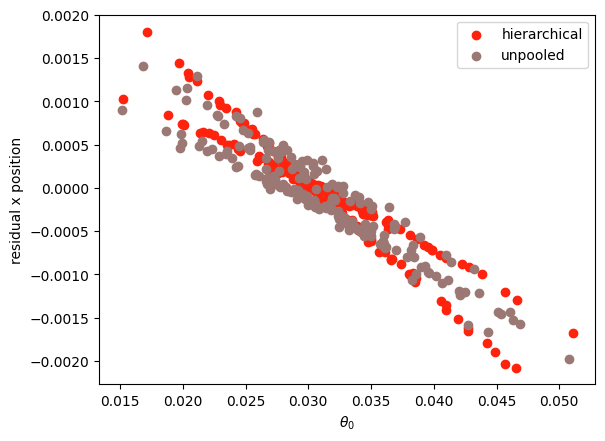

In [286]:
plt.clf()
plt.scatter(df_hierarchical['theta'].values, 
            df_hierarchical['pos'].values - df['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.scatter(df_unpooled['theta'].values, 
            df_unpooled['pos'].values - df['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.xlabel(r'$\theta_0$')
plt.ylabel('residual x position')
plt.legend()
plt.show()

If we flip this on its side and look at the histogram, we see

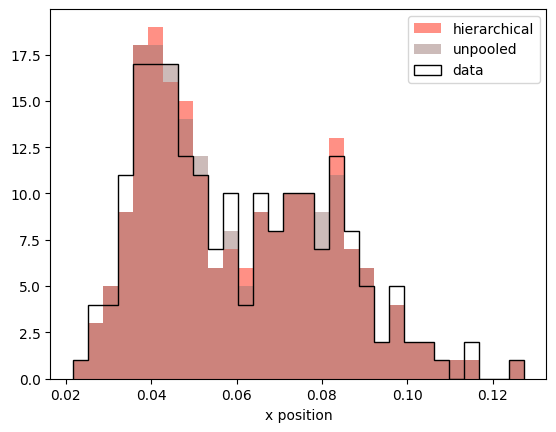

In [298]:
nbins = 30
plt.clf()
xbins, bins = np.histogram(df['pos'].values, bins = nbins)
plt.hist(df_hierarchical['pos'].values,
         bins = bins,
         color = '#FF220C',
         label = 'hierarchical',
         alpha = 0.5
        )
plt.hist(df_unpooled['pos'].values,
         bins = bins,
         color = '#9B7874',
         label = 'unpooled',
         alpha = 0.5
        )
plt.hist(df['pos'].values,
         bins = bins,
         color = 'black',
         label = 'data',
         histtype='step',
         fill = False
        )
plt.xlabel('x position')
plt.legend()
plt.show()

The histograms of x position look the same for all distributions because they are predicting the mean. This is why its important to look at point estimates as well.

Let's look at a different variable and how the predicted values and residuals trend with it.

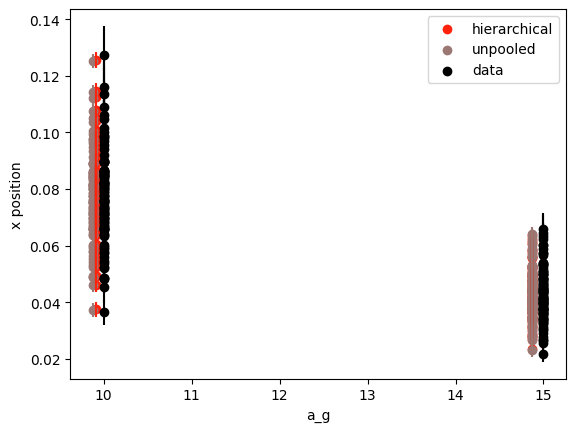

In [287]:
variable = 'a_g'
plt.clf()
plt.scatter(df_hierarchical[variable].values, 
            df_hierarchical['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.errorbar(df_hierarchical[variable].values, 
            df_hierarchical['pos'].values,
            yerr = df_hierarchical['pos_err'].values,
            color = '#FF220C',
            ls = 'None')
plt.scatter(df_unpooled[variable].values, 
            df_unpooled['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.errorbar(df_unpooled[variable].values, 
            df_unpooled['pos'].values,
            yerr = df_unpooled['pos_err'].values,
            color = '#9B7874',
            ls = 'None')
plt.scatter(df[variable].values,
            df['pos'].values,
            color = 'black',
            label = 'data')
plt.errorbar(df[variable].values,
            df['pos'].values,
            yerr = df['pos_err'].values,
            color = 'black',
            ls = 'None')
plt.xlabel(variable)
plt.ylabel('x position')
plt.legend()
plt.show()

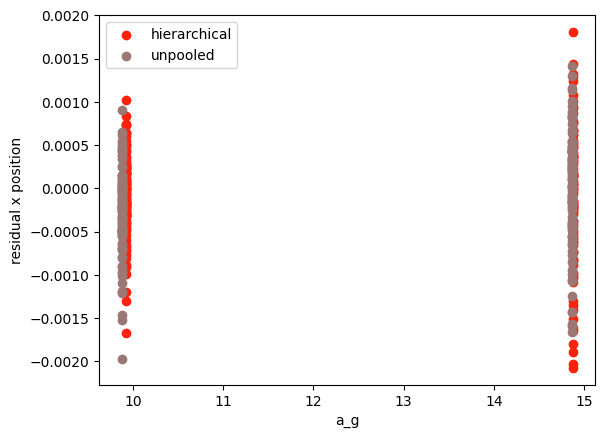

In [288]:
plt.clf()
plt.scatter(df_hierarchical[variable].values, 
            df_hierarchical['pos'].values - df['pos'].values,
            color = '#FF220C',
            label = 'hierarchical')
plt.scatter(df_unpooled[variable].values, 
            df_unpooled['pos'].values - df['pos'].values,
            color = '#9B7874',
            label = 'unpooled')
plt.xlabel(variable)
plt.ylabel('residual x position')
plt.legend()
plt.show()

In [ ]:
xbins, bins = np.histogram(posterior_samples_hierarchical['obs'], bins = 100)


plt.hist(df['pos'].values, bins = bins, alpha = 0.5, density = True, label = 'data')
plt.hist(posterior_samples_hierarchical['obs'], bins = bins, alpha = 0.5, color = '#FF220C', density = True, label = 'hierarchical')
plt.hist(posterior_samples_unpooled['obs'], bins = bins, alpha = 0.5, color = '#9B7874', density = True, label = 'unpooled')
plt.xlabel('position')
plt.legend();

In [ ]:
plt.